<a href="https://colab.research.google.com/github/Nahuelito22/ProyectoDS2_Nahuel_Ghilardi/blob/main/Predicci%C3%B3n_Granizo_Nahuel_Ghilardi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de granizo - Nahuel Ghilardi

Modelo de clasificacion de tormentas de granizo segun variables climaticas

## Introduccion

### Descripcion del proyecto

Este proyecto se enfoca en la predicción de tormentas de granizo, un fenómeno climático que puede tener un impacto significativo en la agricultura, la infraestructura y la seguridad. Utilizando datos históricos de variables climáticas, como temperatura, precipitación, latitud, longitud, y otros factores, el objetivo es crear un modelo predictivo que pueda identificar las condiciones propicias para la ocurrencia de granizo en distintas regiones.

### Motivacion

El proyecto nace de la necesidad de contar con herramientas más precisas para predecir tormentas de granizo, especialmente en regiones como Mendoza, Argentina, donde este fenómeno puede afectar gravemente las cosechas y, por ende, la economía agrícola. La falta de información precisa en tiempo real ha impulsado el interés en desarrollar un modelo predictivo que no solo detecte la ocurrencia de granizo, sino que también ayude a anticipar su posible aparición en el futuro.

### Objetivos

El principal objetivo de este proyecto es desarrollar un modelo de clasificación que sea capaz de predecir la probabilidad de granizo (granizo = 1 / sin granizo = 0), basándose en un conjunto de variables climáticas. Los objetivos específicos incluyen:

1) Explorar los datos climáticos disponibles y preprocesarlos para su uso en modelos de machine learning.

2) Entrenar un modelo predictivo utilizando algoritmos de clasificación como Random Forest, XGBoost, y otros.

3) Evaluar la eficacia del modelo utilizando métricas estándar como precisión, recall, F1-score, matriz de confusión y curva AUC-ROC.

4) Interpretar el modelo utilizando herramientas de interpretabilidad como SHAP para entender qué variables tienen mayor impacto en la predicción del granizo.

### Hipotesis

Se plantea que variables como la latitud, longitud, temperatura, precipitación, altitud y presión atmosférica pueden ser claves en la predicción de la ocurrencia de granizo. Específicamente, se espera que ciertas combinaciones de estas variables puedan permitir una predicción precisa, dada la correlación histórica entre estos factores y los eventos de granizo en diversas regiones.

##Subida de datasets

Importamos librerias para manejo de datos y visualizacion de los mismos.

In [ ]:
# Importar librerias para analisis de datos, normalizacion y visualisacion.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

Instalamos la libreria Meteostat para poder hacer uso de sus herramientas y su api

In [ ]:
# Instalar libreria Meteostat para utilizar su api
!pip install meteostat

Configuramos las dependencias de la libreria Meteostat y los recursos adicionales que pide para un correcto funcionamiento

In [ ]:
# Importar librerias necesarias para el uso de Meteostat
from datetime import datetime
from meteostat import Normals,Stations,Point,Daily,Hourly,Monthly

In [ ]:
# Cargamos los datasets desde github.
frecuencia = pd.read_csv('https://raw.githubusercontent.com/Nahuelito22/ProyectoDS2_Nahuel_Ghilardi/refs/heads/main/Datasets%20Romina%20Nahir/frecuencia.csv',header=None)
# Colocar indices para las columnas
frecuencia.columns = ['ID_Estacion', 'Nombre', 'Latitud', 'Longitud', 'Altitud', 'Año', 'Frecuencia_Granizo']

Hacemos una mirada superficial del Datasets para observar su estructura

In [ ]:
frecuencia

,ID_Estacion,Nombre,Latitud,Longitud,Altitud,Año,Frecuencia_Granizo
0,10196,AZUL-AERO,-36.75,-59.83,132.0,1934,3
1,10196,AZUL-AERO,-36.75,-59.83,132.0,1935,0
2,10196,AZUL-AERO,-36.75,-59.83,132.0,1936,1
3,10196,AZUL-AERO,-36.75,-59.83,132.0,1937,2
4,10196,AZUL-AERO,-36.75,-59.83,132.0,1938,3
...,...,...,...,...,...,...,...
5536,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2015,0
5537,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2016,1
5538,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2017,1
5539,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2018,0


Revisamos la cantidad de registros y posibles nulos

In [ ]:
frecuencia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5541 entries, 0 to 5540
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Estacion         5541 non-null   int64  
 1   Nombre              5541 non-null   object 
 2   Latitud             5541 non-null   float64
 3   Longitud            5541 non-null   float64
 4   Altitud             5541 non-null   float64
 5   Año                 5541 non-null   int64  
 6   Frecuencia_Granizo  5541 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 303.1+ KB


In [ ]:
# Revisamos que no tenga datos nulos
frecuencia.isnull().sum()/100

,0
ID_Estacion,0.0
Nombre,0.0
Latitud,0.0
Longitud,0.0
Altitud,0.0
Año,0.0
Frecuencia_Granizo,0.0


Este datasets contiene fechas desde 1935 hasta 2020, para su utilizacion vamos a recortar un periodo de tiempo ya que la api de Meteostat no contiene suficientes datos para cubrir este periodo de tiempo

In [ ]:
# Definir el rango de años
anio_inicio = 1970
anio_fin = 2019

# Filtrar los datos en el rango de años
datos_filtrados = frecuencia[(frecuencia['Año'] >= anio_inicio) & (frecuencia['Año'] <= anio_fin)]

# Calcular la cantidad de datos en el rango
cantidad_filtrada = len(datos_filtrados)

# Calcular el porcentaje de datos respecto al total
total_datos = len(frecuencia)
porcentaje = (cantidad_filtrada / total_datos) * 100

# Mostrar resultados
print(f"Datos entre {anio_inicio} y {anio_fin}: {cantidad_filtrada}")
print(f"Porcentaje respecto al total: {porcentaje:.2f}%")


Datos entre 1970 y 2019: 4010
Porcentaje respecto al total: 72.37%


Como se ve el codigo anterior, nos proporciona la cantida de registros que se obtienen al recortar el datasets en un periodo especifico de tiempo, y ademas cuanto porcentaje del datasets utilizaremos.

### Utilizar api de Meteostat

Para agregar las variables climaticas a utilizar en el proyecto y combinar con el datasets, utilizaremos https://dev.meteostat.net/
Ya que esta plataforma de codigo abierto proporciona acceso gratuito a datos históricos meteorológicos y climáticos.

Cargamos el datasets principal (Frecuencia) a un dataframe para combinar los datos

In [ ]:
df = frecuencia

A continuacion usaremos el nuevo dataframe.
Lo primero que hacemos es filtrar las fechas de acuerdo con lo que decidimos anteriormente.
Luego generamos una funcion especifica de la documentacion de meteostat y python, para extraer a cada estacion meteorologica sus datos climaticos correspondientes, como son:
* tmax: La temperatura máxima del aire en °C
* tmin: La temperatura mínima del aire en °C
* tavg: La temperatura media del aire en °C
* prcp: La precipitación total anual en mm
* tsun: Total de horas de sol mensuales en minutos ( m )
* wspd: La velocidad media del viento en km/h
* pres: La presión media del aire a nivel del mar en hPa

In [ ]:
# Filtrar rango de fechas (1970 a 2019)
df = df[(df['Año'] >= 1970) & (df['Año'] <= 2019)]

# Dataframe para combinar frecuencia con df nuevo.
datos_combinados = []

# Iterar con las cordenadas de cada estacion y los metodos de meteostat
for _, row in df.iterrows():
    # Seleccionar la latitud, longitud, y año de la fila actual
    latitud = row['Latitud']
    longitud = row['Longitud']
    año = row['Año']

    # Crear un objeto Point para la estación
    estacion = Point(latitud, longitud)

    # Establecer el rango de fechas (enero a diciembre del año actual)
    inicio = datetime(año, 1, 1)
    fin = datetime(año, 12, 31)

    # Descargar datos diarios de la estación
    datos_diarios = Daily(estacion, inicio, fin).fetch()

    # Calcular promedios anuales para las variables climáticas
    promedio_anual = {
        'ID_Estacion': row['ID_Estacion'],
        'Nombre': row['Nombre'],
        'Año': año,
        'Temp_Max': datos_diarios['tmax'].mean(),
        'Temp_Min': datos_diarios['tmin'].mean(),
        'Temp_Media': datos_diarios['tavg'].mean(),
        'Viento_kmH': datos_diarios['wspd'].mean(),
        'Presion_Hpa': datos_diarios['pres'].mean(),
        'Precipitacion': datos_diarios['prcp'].sum(),  # Suma total de precipitación anual
        'Horas_Sol': datos_diarios['tsun'].sum() if 'tsun' in datos_diarios.columns else None  # Horas de sol
    }

    # Añadir al nuevo DataFrame
    datos_combinados.append(promedio_anual)

# Convertir la lista de diccionarios a un DataFrame final
df_climatico = pd.DataFrame(datos_combinados)

# Imputación de valores faltantes mediante interpolación lineal
df_climatico[['Temp_Max', 'Temp_Min', 'Temp_Media', 'Precipitacion','Viento_kmH','Presion_Hpa','Horas_Sol']] = df_climatico[
    ['Temp_Max', 'Temp_Min', 'Temp_Media', 'Precipitacion','Viento_kmH','Presion_Hpa','Horas_Sol']
].interpolate(method='linear')

# Combinar los datos climáticos con el dataset principal
df_final = pd.merge(df, df_climatico, on=['ID_Estacion', 'Nombre', 'Año'])

# Agregar columna de granizo para la prediccion (Sí/No)
df_final['Granizo_Si_No'] = df_final['Frecuencia_Granizo'].apply(lambda x: 'Sí' if x > 0 else 'No')

# Guardar el dataset combinado a un nuevo archivo CSV
df_final.to_csv('dataset_con_datos_climaticos.csv', index=False)

print("¡Datos combinados, imputados y guardados correctamente!")

El codigo anterior ademas de proporcionarnos los datos climaticos,filtrarlos por estacion y año correspondiente, genera una nueva columna que nos indica si ese año hubo o no granizo segun la frecuencia.

Este codigo ademas tiene un proceso de interpolacion lineal para estimar aquellos valores desconocidos dentro de un rango de datos conocidos.

Igualmente esa interpolacion se hace en menor medida ya que los datos de meteostat vienen con un previo filtrado para evitar errores.

In [ ]:
# Comprobamos si aun tenemos datos nulos
df_final.isnull().sum()/100

,0
ID_Estacion,0.00
Nombre,0.00
Latitud,0.00
Longitud,0.00
Altitud,0.00
Año,0.00
Frecuencia_Granizo,0.00
Temp_Max,0.25
Temp_Min,0.25
Temp_Media,0.28


Vamos a visualizar como quedo el dataframe combinado con los datos climaticos y la frecuencia del granizo

In [ ]:
df_final

,ID_Estacion,Nombre,Latitud,Longitud,Altitud,Año,Frecuencia_Granizo,Temp_Max,Temp_Min,Temp_Media,Viento_kmH,Presion_Hpa,Precipitacion,Granizo_Si_No
0,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1973,2,21.318082,8.448219,14.362810,27.800000,1016.500000,248.8,Sí
1,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1974,1,22.111233,8.426849,15.025895,27.691667,1018.725000,728.0,Sí
2,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1975,1,22.175890,9.043836,15.393315,29.370330,1012.874286,42.2,Sí
3,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1976,1,20.574044,7.889344,14.774590,31.680769,1009.433333,342.9,Sí
4,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1977,1,22.123562,8.592329,15.082967,24.743820,1013.954762,1250.5,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2015,0,25.596875,8.945480,16.216164,6.255814,1012.040000,1029.9,No
3978,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2016,1,24.847826,8.065015,15.700000,6.255814,1012.040000,934.7,Sí
3979,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2017,1,26.228804,8.174929,16.216986,6.255814,1012.040000,801.1,Sí
3980,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2018,0,26.351852,8.201709,16.294780,6.255814,1012.040000,501.2,No


Como se observa vemos que tenemos algunos datos nulos en temperatura media, maxima, minima,viento y presion.

Primero vamos a ver si los datos son de varias estaciones o son estaciones unicas y donde es su locacalizacion.

### Analisis de posibles nulos y columnas vacias

In [ ]:

# Cargar el DataFrame principal
df = df_final.copy()

# Calcular la cantidad de datos nulos por estación
nulos_por_estacion = df.groupby(['ID_Estacion', 'Nombre']) \
    .apply(lambda x: x.isnull().sum().sum()) \
    .reset_index(name='Cantidad_Nulos')

# Ordenar por la cantidad de nulos en orden descendente
nulos_por_estacion = nulos_por_estacion.sort_values(by='Cantidad_Nulos', ascending=False)

# Imprimir las 10 estaciones con más valores nulos
print(nulos_por_estacion.head(5))


    ID_Estacion                   Nombre  Cantidad_Nulos
43        10196                AZUL-AERO             125
47        10221        BAHIA BLANCA-AERO               9
0         10001                LA QUIACA               0
59        10298             USHUAIA-AERO               0
67        10332  BUENOS AIRES/AEROPARQUE               0


Como se puede leer las estaciones Azul-Aero y Bahia Blanca-Aero son las que mas nulos poseen, ahora vamos a visualizarlas en el mapa para poder ver si son relevantes en su posicion o tiene mas vecinos cercanos.

Para ello reutilizamos la formula para filtrar nulos pero esta vez se utilizara para el grafico

In [ ]:
# Cargamos dataframe para formula y para el grafico
df = df_final.copy()
df_combinado = df_final.copy()

# Cantidad de nulos por erta
nulos_por_estacion = df.groupby(['ID_Estacion', 'Nombre']) \
    .apply(lambda x: x.isnull().sum().sum()) \
    .reset_index(name='Cantidad_Nulos')


# Merge de nulos_por_estacion con df_combinado para agregar la columna 'Cantidad_Nulos' a las estaciones
df_combinado = pd.merge(df_combinado, nulos_por_estacion[['ID_Estacion', 'Cantidad_Nulos']], on='ID_Estacion', how='left')

# Crear una nueva columna que clasifique las estaciones en 'Sin Nulos' y 'Con Nulos'
df_combinado['Estatus'] = df_combinado['Cantidad_Nulos'].apply(lambda x: 'Con Nulos' if x > 0 else 'Sin Nulos')

# Crear el mapa interactivo
fig = px.scatter_mapbox(df_combinado,
                        lat="Latitud", lon="Longitud",
                        color="Estatus",
                        color_discrete_map={"Sin Nulos": "blue", "Con Nulos": "red"},
                        hover_data=["ID_Estacion", "Cantidad_Nulos"],
                        title="Estaciones con y sin Nulos en Argentina",
                        mapbox_style="carto-positron")

# Ajustar la vista del mapa para que enfoque Argentina
fig.update_layout(mapbox=dict(center={"lat": -38, "lon": -63}, zoom=4))

# Mostrar el gráfico
fig.show()


Como vemos ambas estaciones son parte de un cumulo grande de estaciones en Buenos Aires y su eliminacion devido a gran cantidad de nulos no significaria un problema en el datasets general.

In [ ]:
# Eliminar datos nulos
df_final = df_final.dropna()

Luego de revisar los nulos, nuevamente prestaremos atencion al datasets para ver si encontramos otra irregularidades

In [ ]:
df_final

,ID_Estacion,Nombre,Latitud,Longitud,Altitud,Año,Frecuencia_Granizo,Temp_Max,Temp_Min,Temp_Media,Viento_kmH,Presion_Hpa,Precipitacion,Horas_Sol,Granizo_Si_No
28,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1973,2,21.318082,8.448219,14.362810,27.800000,1016.500000,248.8,0.0,Sí
29,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1974,1,22.111233,8.426849,15.025895,27.691667,1018.725000,728.0,0.0,Sí
30,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1975,1,22.175890,9.043836,15.393315,29.370330,1012.874286,42.2,0.0,Sí
31,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1976,1,20.574044,7.889344,14.774590,31.680769,1009.433333,342.9,0.0,Sí
32,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1977,1,22.123562,8.592329,15.082967,24.743820,1013.954762,1250.5,0.0,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4005,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2015,0,25.596875,8.945480,16.216164,6.255814,1012.040000,1029.9,0.0,No
4006,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2016,1,24.847826,8.065015,15.700000,6.255814,1012.040000,934.7,0.0,Sí
4007,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2017,1,26.228804,8.174929,16.216986,6.255814,1012.040000,801.1,0.0,Sí
4008,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2018,0,26.351852,8.201709,16.294780,6.255814,1012.040000,501.2,0.0,No


Viendo el dataframe se sospecha que la api de meteostat no pudo ingresar datos correctos para la columna Horas_Sol, ya que como se ve contiene todos 0

Para estar seguros de esto vamos a ver si posee otros valores

In [ ]:
# Valores unicos de la columna Horas_Sol
print('Valores unicos de la columna Horas_Sol',df_final['Horas_Sol'].unique())

Valores unicos de la columna Horas_Sol [0.]


Ahora que sabemos con exactitud que no posee valores que aporten algo al modelo vamos a proceder a borrar la columna.

In [ ]:
df_final = df_final.drop('Horas_Sol', axis=1)


In [ ]:
df_final = df_final.reset_index(drop=True)
df_final

,ID_Estacion,Nombre,Latitud,Longitud,Altitud,Año,Frecuencia_Granizo,Temp_Max,Temp_Min,Temp_Media,Viento_kmH,Presion_Hpa,Precipitacion,Granizo_Si_No
0,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1973,2,21.318082,8.448219,14.362810,27.800000,1016.500000,248.8,Sí
1,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1974,1,22.111233,8.426849,15.025895,27.691667,1018.725000,728.0,Sí
2,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1975,1,22.175890,9.043836,15.393315,29.370330,1012.874286,42.2,Sí
3,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1976,1,20.574044,7.889344,14.774590,31.680769,1009.433333,342.9,Sí
4,10221,BAHIA BLANCA-AERO,-38.73,-62.17,83.0,1977,1,22.123562,8.592329,15.082967,24.743820,1013.954762,1250.5,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2015,0,25.596875,8.945480,16.216164,6.255814,1012.040000,1029.9,No
3978,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2016,1,24.847826,8.065015,15.700000,6.255814,1012.040000,934.7,Sí
3979,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2017,1,26.228804,8.174929,16.216986,6.255814,1012.040000,801.1,Sí
3980,10335,VILLA REYNOLDS-AERO,-33.73,-65.38,486.0,2018,0,26.351852,8.201709,16.294780,6.255814,1012.040000,501.2,No


## Analisis de variables

### Frecuencia a lo largo del tiempo

Ahora que tenemos el datasets limpio podemos ver como evoluciono la frecuencia del granizo a lo largo del tiempo y si es que esta aumento

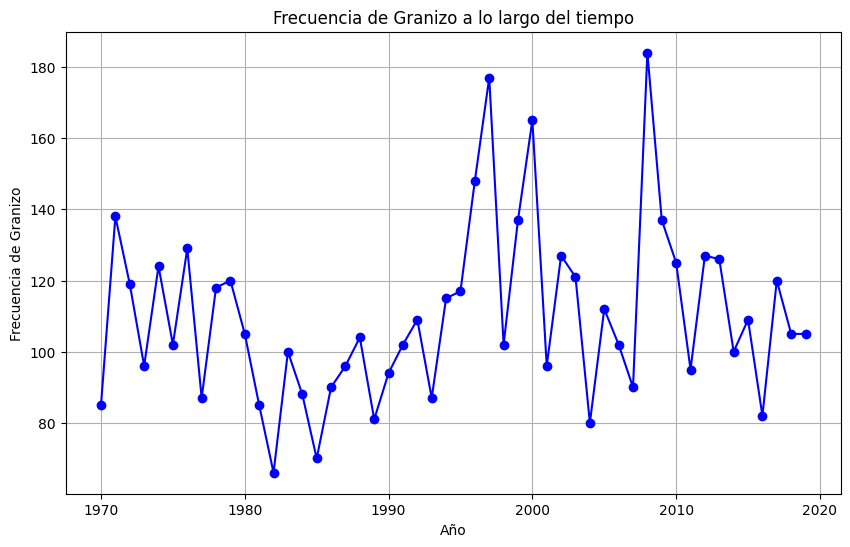

In [ ]:
df_copy = df_final.copy()

# Agrupar por año y calcular la frecuencia total de granizo
frecuencia_granizo = df_copy.groupby('Año')['Frecuencia_Granizo'].sum()

# Crear gráfico de la frecuencia de granizo a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.plot(frecuencia_granizo.index, frecuencia_granizo.values, marker='o', color='b')
plt.title('Frecuencia de Granizo a lo largo del tiempo')
plt.xlabel('Año')
plt.ylabel('Frecuencia de Granizo')
plt.grid(True)
plt.show()


De este grafico pueden surgir varias hipotesis, ya que a simple vista no tenemos un patron significativo.



*   La primera hipotesis que puede surgir, es que hubo algun evento que provoco un aumento significativo en la frecuencia del granizo entre 1995 y 2008
*   La otra hipotesis que contrarresta a la anterior, es que quizas ese aumento significativo se debe a la construccion de nuevas estacciones meteorologicas.
*   Pero asi mismo la ultima hipotesis que puede surgir es. Si hubo un crecimiento en el area de infraestructura meteorologica, porque luego del 2010 la frecuencia vuelve a estancarse. ¿Sera un fenomeno temporal a largo plazo?





### Evolución de la Frecuencia de Granizo vs. Cantidad de Estaciones Reportadas por Año

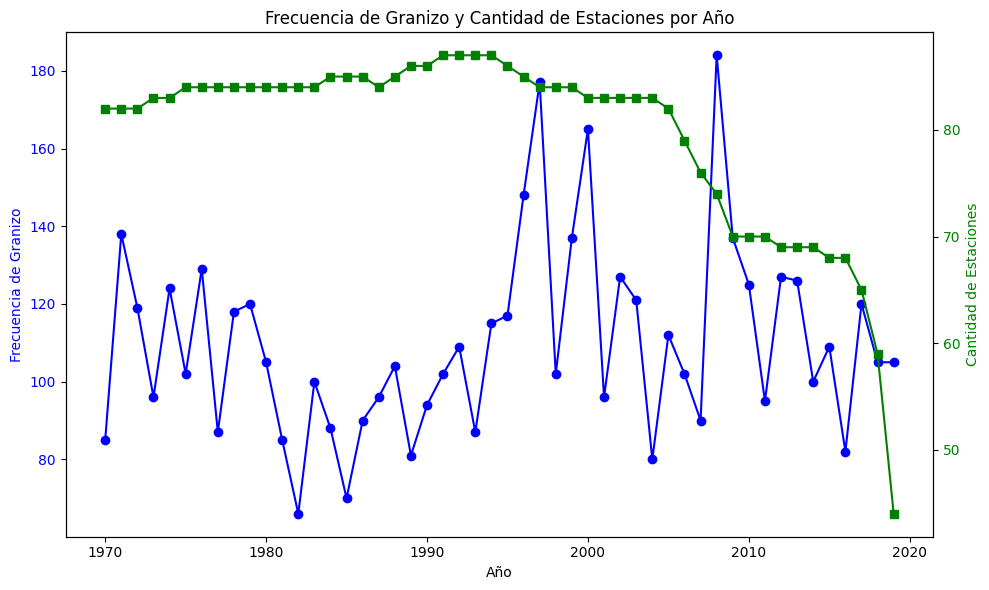

In [ ]:
df_copy = df_final.copy()

frecuencia_granizo_por_ano = df_copy.groupby('Año')['Frecuencia_Granizo'].sum()

# Contar el número de estaciones por año (suponiendo que la columna 'ID_Estacion' identifica cada estación)
cantidad_estaciones_por_ano = df_copy.groupby('Año')['ID_Estacion'].nunique()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje 1
ax1.set_xlabel('Año')
ax1.set_ylabel('Frecuencia de Granizo', color='b')
ax1.plot(frecuencia_granizo_por_ano.index, frecuencia_granizo_por_ano.values, marker='o', color='b', label='Frecuencia de Granizo')
ax1.tick_params(axis='y', labelcolor='b')

# Eje 2
ax2 = ax1.twinx()
ax2.set_ylabel('Cantidad de Estaciones', color='g')
ax2.plot(cantidad_estaciones_por_ano.index, cantidad_estaciones_por_ano.values, marker='s', color='g', label='Cantidad de Estaciones')
ax2.tick_params(axis='y', labelcolor='g')

# Título
plt.title('Frecuencia de Granizo y Cantidad de Estaciones por Año')
fig.tight_layout()
plt.show()


Como se puede observar, la fluctuación en la frecuencia de granizo no es proporcional a un aumento significativo en la cantidad de estaciones que registraron dicho evento.

### Relación entre la Frecuencia de Granizo y la Temperatura Media Anual

¿Quizás un aumento o descenso significativo en la temperatura provoca estos cambios tan erráticos?

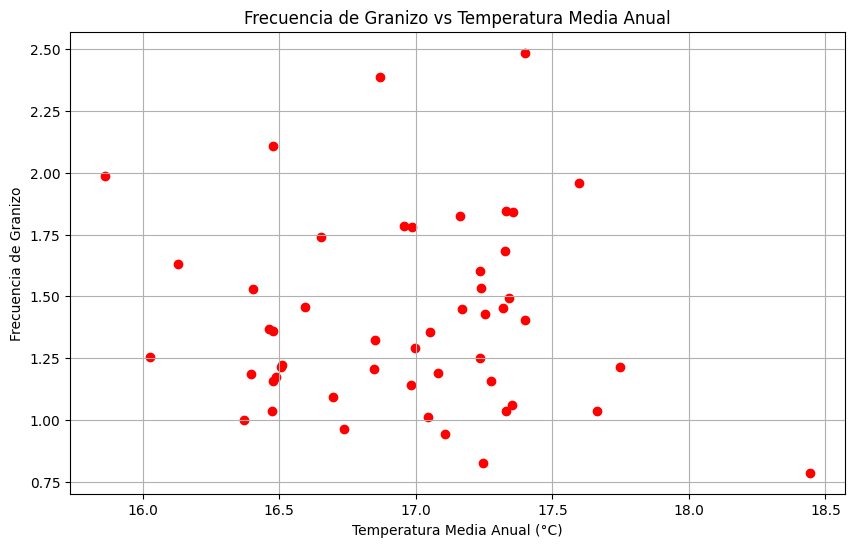

In [ ]:
# Agrupar por año y calcular la temperatura media anual y la frecuencia de granizo
granizo_temp = df_copy.groupby('Año')[['Frecuencia_Granizo', 'Temp_Media']].mean()

# Crear gráfico de dispersión entre frecuencia de granizo y temperatura media
plt.figure(figsize=(10, 6))
plt.scatter(granizo_temp['Temp_Media'], granizo_temp['Frecuencia_Granizo'], color='r')
plt.title('Frecuencia de Granizo vs Temperatura Media Anual')
plt.xlabel('Temperatura Media Anual (°C)')
plt.ylabel('Frecuencia de Granizo')
plt.grid(True)
plt.show()


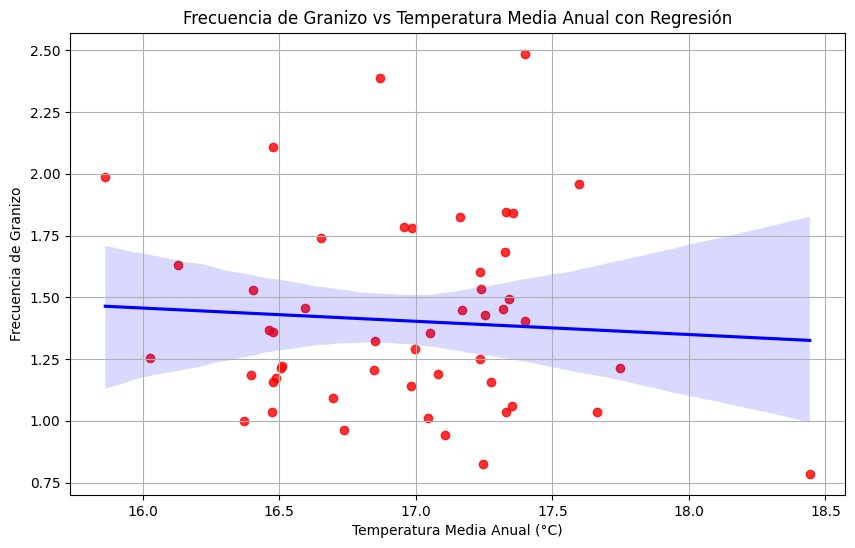

In [ ]:
# Crear gráfico de dispersión con regresión
plt.figure(figsize=(10, 6))
sns.regplot(x='Temp_Media', y='Frecuencia_Granizo', data=granizo_temp, scatter_kws={'color': 'r'}, line_kws={'color': 'b'})
plt.title('Frecuencia de Granizo vs Temperatura Media Anual con Regresión')
plt.xlabel('Temperatura Media Anual (°C)')
plt.ylabel('Frecuencia de Granizo')
plt.grid(True)
plt.show()


Como se observa en ambos gráficos, podemos extraer información relevante, como el hecho de que la mayoría de los registros de granizo se obtuvieron en un rango de temperatura superficial de 16.5°C a 17.5°C. Sin embargo, este dato tiene limitaciones, ya que las tormentas donde se genera el granizo ocurren a altitudes entre 3 y 12 km, donde las condiciones de temperatura y presión son distintas.

Obtener información precisa sobre estas capas superiores requiere herramientas avanzadas como imágenes satelitales, radares meteorológicos o simulaciones atmosféricas. Aun así, estos datos nos permiten aproximarnos al problema desde una perspectiva útil para clasificar eventos potenciales de granizo, lo que podría ser valioso para futuros modelos predictivos.

### Impacto de Presión, Viento y Precipitación en la Frecuencia de Granizo

Ahora analizaremos otras variables que podrían influir en la formación de tormentas de granizo y ayudarnos a mejorar su clasificación.

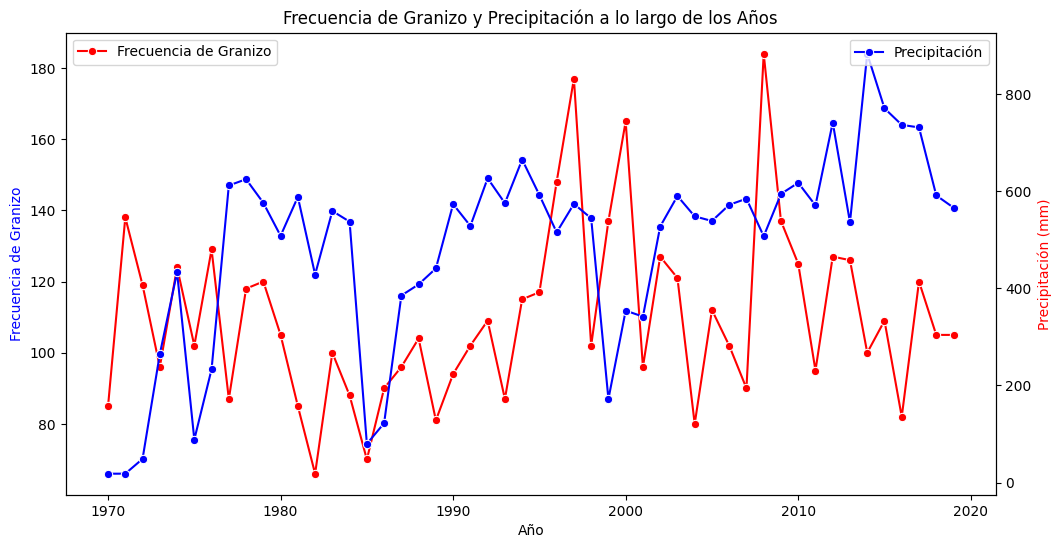

In [ ]:
df_copia = df_final.copy()

# Agrupar los datos por año y calcular la suma de la frecuencia del granizo y la precipitación promedio
df_agrupado = df_copia.groupby('Año').agg({
    'Frecuencia_Granizo': 'sum',
    'Precipitacion': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=df_agrupado, x='Año', y='Frecuencia_Granizo', label='Frecuencia de Granizo', color='red', marker='o', ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(data=df_agrupado, x='Año', y='Precipitacion', label='Precipitación', color='blue', marker='o', ax=ax2)

ax1.set_title('Frecuencia de Granizo y Precipitación a lo largo de los Años')
ax1.set_xlabel('Año')
ax1.set_ylabel('Frecuencia de Granizo', color='blue')
ax2.set_ylabel('Precipitación (mm)', color='red')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Como se puede observar, no hay una relación directa, es decir, una variable no influye directamente en la otra. Sin embargo, es cierto que en ciertas épocas se pueden observar correlaciones positivas o negativas.



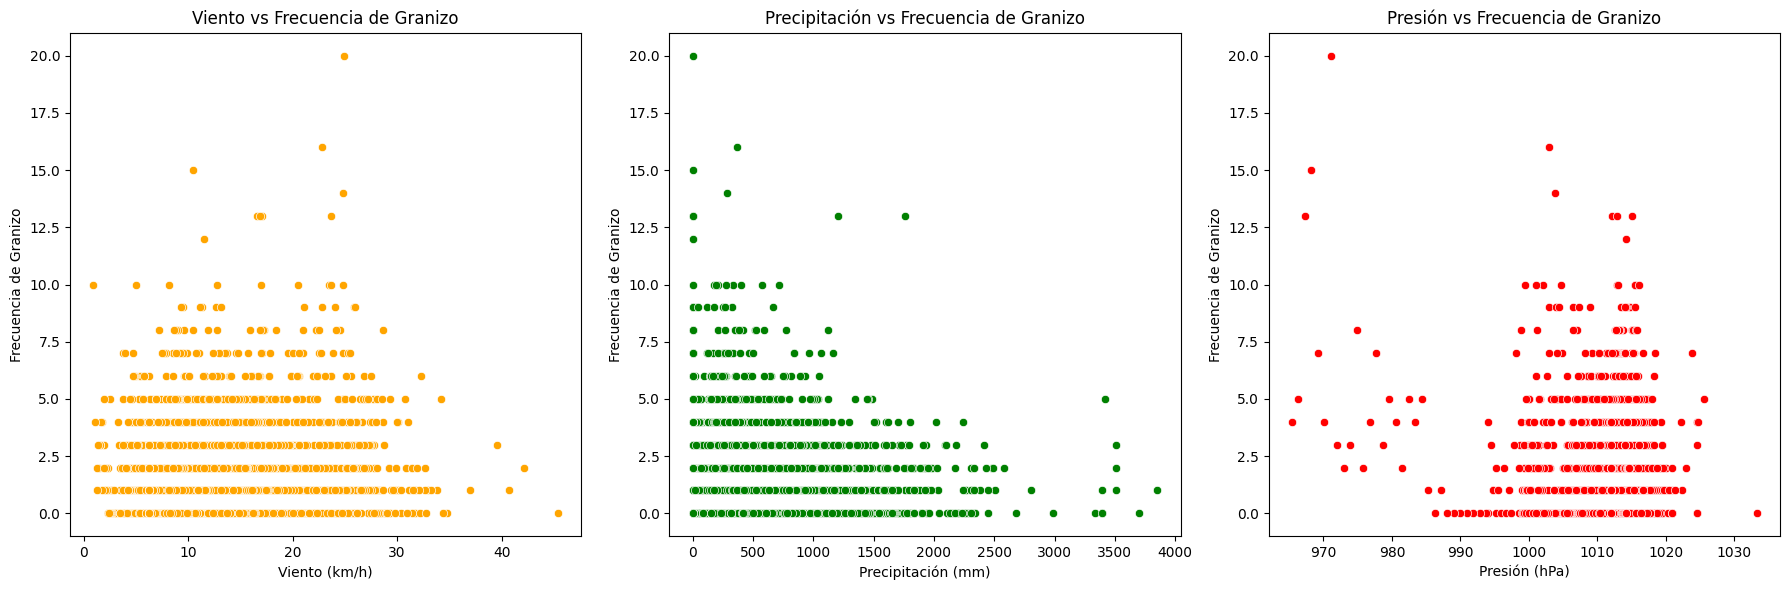

In [ ]:
df_copia = df_final.copy()
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Viento vs Frecuencia
sns.scatterplot(data=df_copia, x='Viento_kmH', y='Frecuencia_Granizo', ax=axes[0], color='orange')
axes[0].set_title('Viento vs Frecuencia de Granizo')
axes[0].set_xlabel('Viento (km/h)')
axes[0].set_ylabel('Frecuencia de Granizo')

# Precipitación vs Frecuencia
sns.scatterplot(data=df_copia, x='Precipitacion', y='Frecuencia_Granizo', ax=axes[1], color='green')
axes[1].set_title('Precipitación vs Frecuencia de Granizo')
axes[1].set_xlabel('Precipitación (mm)')
axes[1].set_ylabel('Frecuencia de Granizo')

# Presión vs Frecuencia
sns.scatterplot(data=df_copia, x='Presion_Hpa', y='Frecuencia_Granizo', ax=axes[2], color='red')
axes[2].set_title('Presión vs Frecuencia de Granizo')
axes[2].set_xlabel('Presión (hPa)')
axes[2].set_ylabel('Frecuencia de Granizo')

plt.tight_layout()
plt.show()

En estas comparaciones, logramos ver que el evento del granizo es algo tan dificl de predecir ya que para aquellos parametros similares puede o no haber granizo, pero lo que si se logra ver son cifras que dejan claro cuando es raro que una tormenta de granizo se forme.

<ipython-input-27-3cf5ccb1eb2d>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-27-3cf5ccb1eb2d>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-27-3cf5ccb1eb2d>:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




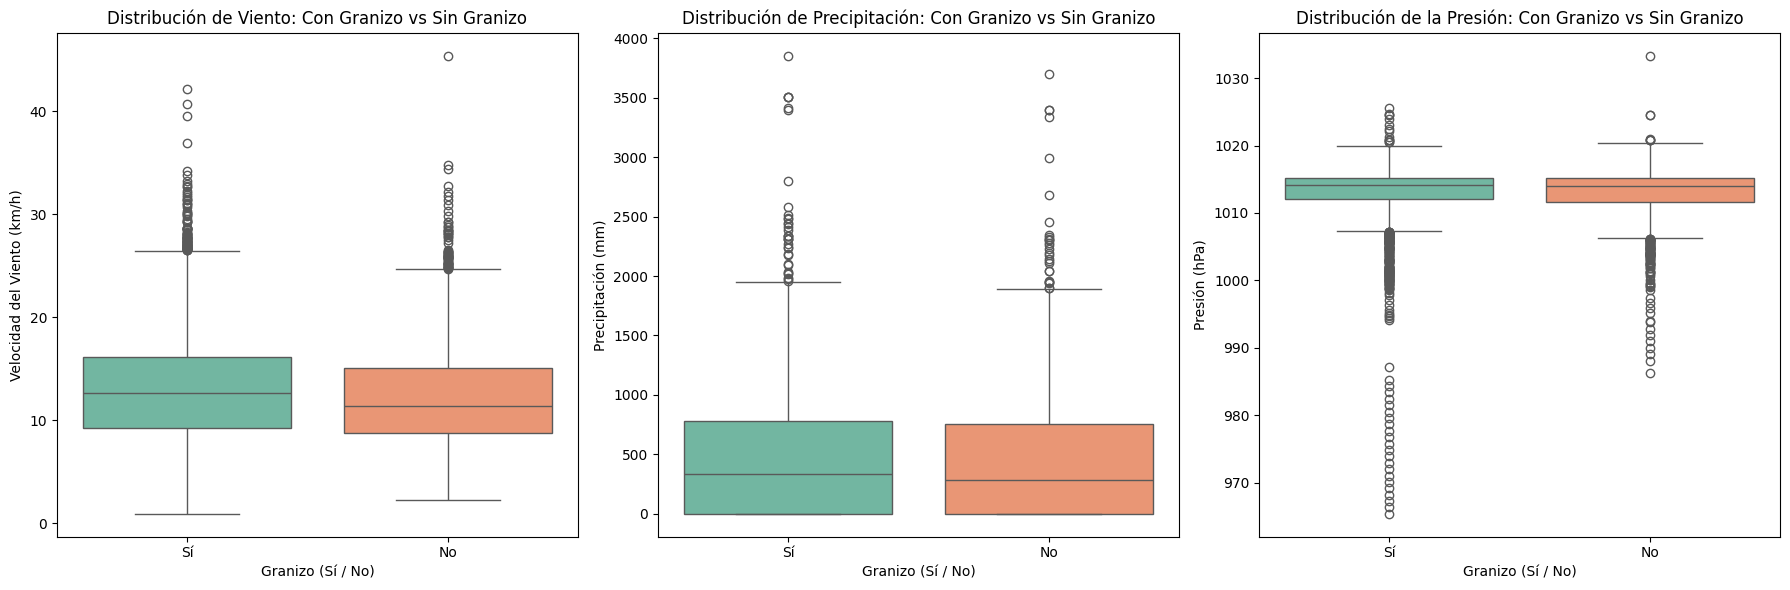

In [ ]:
df_copia = df_final.copy()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Viento
sns.boxplot(x='Granizo_Si_No', y='Viento_kmH', data=df_copia, palette="Set2", ax=axes[0])
axes[0].set_title('Distribución de Viento: Con Granizo vs Sin Granizo')
axes[0].set_ylabel('Velocidad del Viento (km/h)')
axes[0].set_xlabel('Granizo (Sí / No)')

# Precipitación
sns.boxplot(x='Granizo_Si_No', y='Precipitacion', data=df_copia, palette="Set2", ax=axes[1])
axes[1].set_title('Distribución de Precipitación: Con Granizo vs Sin Granizo')
axes[1].set_ylabel('Precipitación (mm)')
axes[1].set_xlabel('Granizo (Sí / No)')

# Presión
sns.boxplot(x='Granizo_Si_No', y='Presion_Hpa', data=df_copia, palette="Set2", ax=axes[2])
axes[2].set_title('Distribución de la Presión: Con Granizo vs Sin Granizo')
axes[2].set_ylabel('Presión (hPa)')
axes[2].set_xlabel('Granizo (Sí / No)')

plt.tight_layout()
plt.show()


Tras analizar estos gráficos, llegamos a varias conclusiones. Como se puede observar, predecir o clasificar una tormenta de granizo utilizando solo el viento o la precipitación resulta bastante complejo, ya que parece que no hay una relación significativa entre estas variables.

Sin embargo, como se observa en el gráfico de presión, esta variable sí nos es de bastante ayuda, ya que las tormentas de granizo suelen formarse en sistemas de baja presión, lo cual es consistente con lo que muestra el Boxplot.

### Distribución Geográfica de Tormentas de Granizo en Argentina

Utilizaremos Geopandas para la visualizacion por provincia.

Ademas descargamos el mapa de Argentina desde https://gadm.org/.

Esto se hace para poder obtener los limites por provincia por latitud y longitud y luego filtrarlo con el dataset nuestro

In [ ]:
# Importamos librerias necesarias para extraer y manejar archivos zip
import os
import requests
from zipfile import ZipFile

url_zip = 'https://github.com/Nahuelito22/ProyectoDS2_Nahuel_Ghilardi/raw/main/gadm41_ARG_shp/gadm41_ARG_shp.zip'

#Descarga del zip
zip_path = 'gadm41_ARG_shp.zip'
response = requests.get(url_zip)
with open(zip_path, 'wb') as file:
    file.write(response.content)

#Carepeta para extraer zip
extract_dir = 'gadm41_ARG_shp'
os.makedirs(extract_dir, exist_ok=True)

#Extraer .zip
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Listar archivos extraídos para verificar
print(f"Archivos extraídos: {os.listdir(extract_dir)}")

Archivos extraídos: ['gadm41_ARG_2.shx', 'gadm41_ARG_0.cpg', 'gadm41_ARG_1.shx', 'gadm41_ARG_1.shp', 'gadm41_ARG_1.dbf', 'gadm41_ARG_2.dbf', 'gadm41_ARG_0.shp', 'gadm41_ARG_2.shp', 'gadm41_ARG_2.cpg', 'gadm41_ARG_1.cpg', 'gadm41_ARG_1.prj', 'gadm41_ARG_0.prj', 'gadm41_ARG_0.dbf', 'gadm41_ARG_0.shx', 'gadm41_ARG_2.prj']


In [ ]:
# Importamos geopandas
import geopandas as gpd

shapefile_path = os.path.join(extract_dir, 'gadm41_ARG_1.shp')

# Shapfile a geodataframe
gdf_provincias = gpd.read_file(shapefile_path)

# Verificamos:
print(gdf_provincias.head())


     GID_1 GID_0    COUNTRY                  NAME_1  \
0  ARG.1_1   ARG  Argentina            Buenos Aires   
1  ARG.2_1   ARG  Argentina               Catamarca   
2  ARG.3_1   ARG  Argentina                   Chaco   
3  ARG.4_1   ARG  Argentina                  Chubut   
4  ARG.5_1   ARG  Argentina  Ciudad de Buenos Aires   

                          VARNAME_1 NL_NAME_1            TYPE_1  \
0               Baires|Buenos Ayres        NA         Provincia   
1                                NA        NA         Provincia   
2    El Chaco|Presidente Juan Peron        NA         Provincia   
3                                NA        NA         Provincia   
4  BUENOS AIRES D.F.|Capital Federa        NA  Distrito Federal   

          ENGTYPE_1 CC_1 HASC_1 ISO_1  \
0          Province   NA  AR.BA  AR-B   
1          Province   NA  AR.CT  AR-K   
2          Province   NA  AR.CC  AR-H   
3          Province   NA  AR.CH  AR-U   
4  Federal District   NA  AR.DF    NA   

                   

In [ ]:
# Importamos geopandas y shapely para el manejo de latitud y longitud
from geopandas import GeoDataFrame
from shapely.geometry import Point

# Copia del dataframe original
df_copia = df_final.copy()

# Geometria de puntos por fila
geometry = [Point(xy) for xy in zip(df_copia['Longitud'], df_copia['Latitud'])]
gdf = GeoDataFrame(df_copia, geometry=geometry, crs="EPSG:4326")  # CRS WGS84

gdf_provincias = gdf_provincias.to_crs(gdf.crs)

# Spatial Join
gdf = gpd.sjoin(gdf, gdf_provincias[['NAME_1', 'geometry']], how="left", predicate="within")

# Verificamos:
print(gdf[['Granizo_Si_No', 'Latitud', 'Longitud', 'NAME_1']].head())


  Granizo_Si_No  Latitud  Longitud        NAME_1
0            Sí   -38.73    -62.17  Buenos Aires
1            Sí   -38.73    -62.17  Buenos Aires
2            Sí   -38.73    -62.17  Buenos Aires
3            Sí   -38.73    -62.17  Buenos Aires
4            Sí   -38.73    -62.17  Buenos Aires


In [ ]:
# Verificar si hay filas sin provincia asignada
print(gdf['NAME_1'].isna().sum(), "registros no tienen una provincia asignada.")

# Contar registros por provincia:
print(gdf['NAME_1'].value_counts())


0 registros no tienen una provincia asignada.
NAME_1
Buenos Aires              823
Córdoba                   423
Mendoza                   286
Santa Fe                  229
Corrientes                210
Santa Cruz                193
Chubut                    187
Río Negro                 169
Salta                     145
Entre Ríos                144
Misiones                  144
San Juan                  130
Ciudad de Buenos Aires    100
Jujuy                     100
Formosa                    99
Catamarca                  91
La Rioja                   87
Tierra del Fuego           78
Chaco                      76
San Luis                   62
La Pampa                   61
Neuquén                    50
Santiago del Estero        48
Tucumán                    47
Name: count, dtype: int64


In [ ]:
# Filtrar eventos de granizo
gdf_granizo = gdf[gdf['Granizo_Si_No'] == 'Sí']

# Agrupar por provincia y contar eventos de granizo
df_provincias = gdf_granizo.groupby('NAME_1').size().reset_index(name='Frecuencia_Granizo')

# Verificar los resultados:
print(df_provincias)


                    NAME_1  Frecuencia_Granizo
0             Buenos Aires                 497
1                Catamarca                  38
2                    Chaco                  37
3                   Chubut                 122
4   Ciudad de Buenos Aires                  78
5               Corrientes                 105
6                  Córdoba                 331
7               Entre Ríos                  77
8                  Formosa                  42
9                    Jujuy                  74
10                La Pampa                  55
11                La Rioja                  39
12                 Mendoza                 221
13                Misiones                  88
14                 Neuquén                  23
15               Río Negro                  77
16                   Salta                  58
17                San Juan                  35
18                San Luis                  39
19              Santa Cruz                 144
20           

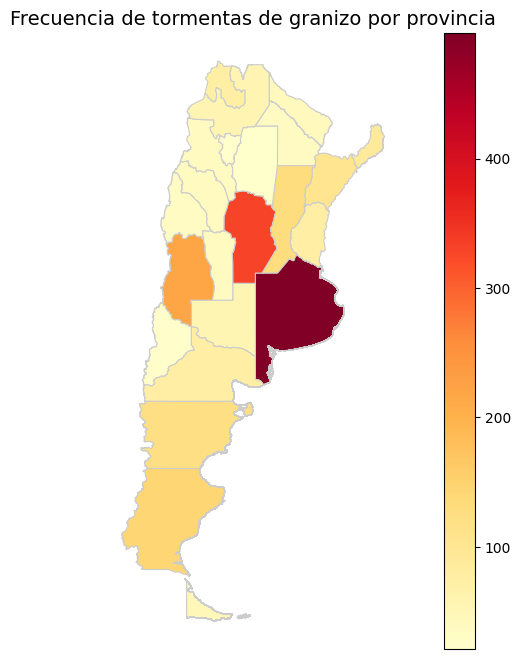

In [ ]:
#Unir los datos de frecuencia con el GeoDataFrame de provincias
gdf_provincias = gdf_provincias.merge(df_provincias, how="left", on="NAME_1")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Dibujar las provincias con la frecuencia de granizo
gdf_provincias.plot(
    column='Frecuencia_Granizo',
    cmap='YlOrRd',
    linewidth=0.8,
    edgecolor='0.8',
    ax=ax,
    legend=True
)

ax.set_title('Frecuencia de tormentas de granizo por provincia', fontsize=14)
ax.axis('off')
plt.show()


Como se observa en el mapa, las tres provincias más afectadas por las tormentas de granizo son:

1. Buenos Aires
2. Córdoba
3. Mendoza

Esto también puede deberse a que en las demás provincias hay menos estaciones meteorológicas; sin embargo, a grandes rasgos, esto resalta la importancia de contar con un sistema capaz de clasificar la probabilidad de una tormenta.




### Top 10 Provincias con Más Frecuencia de Granizo

In [ ]:
# Guardar columnas relevantes para dataframe gdf_provincias
gdf_provincias_filtrado = gdf_provincias[['NAME_1','Frecuencia_Granizo']]


In [ ]:
gdf_provincias_filtrado.head()

,NAME_1,Frecuencia_Granizo
0,Buenos Aires,497
1,Catamarca,38
2,Chaco,37
3,Chubut,122
4,Ciudad de Buenos Aires,78


In [ ]:
# Definir el número de provincias top a mostrar
n = 10  # Puedes cambiar este valor según tus necesidades

# Ordenar el dataframe por la frecuencia de granizo y seleccionar las top n provincias
top_n_provincias = gdf_provincias_filtrado.sort_values(by='Frecuencia_Granizo', ascending=False).head(n)

# Crear el gráfico de barras interactivo con Plotly Express
fig = px.bar(top_n_provincias,
             x='Frecuencia_Granizo',
             y='NAME_1',
             orientation='h',
             color='Frecuencia_Granizo',
             title=f'Top {n} Provincias con Más Frecuencia de Granizo',
             labels={'Frecuencia_Granizo': 'Frecuencia de Granizo', 'NAME_1': 'Provincia'})

# Mostrar el gráfico
fig.show()


Como se ve anteriormente vimos la misma informacion sobre las provincias con mayor registro de tormentas de granizo en un mapa, pero ahora lo que logramos ver es el top 10 provincias y de forma interctivda con sus respectivos datos.

Esto nos ayuda para ver y reflexionar sobre el gran impacto que tienen estas tormentas en nuestras provincias.

### Variable objetivo

Un factor clave a tener en cuenta es que este proyecto no habría sido posible sin el dataset de frecuencias, el cual fue creado por Mezher Romina Nahir.

Como mencionamos anteriormente, este dataset contenía la frecuencia anual de granizo por estación a lo largo de los años. Dado que es muy complejo obtener datos específicos sobre tormentas de granizo, utilizamos las frecuencias positivas para etiquetar granizo = sí y las negativas como granizo = no, lo que permitió generar un modelo clasificador. Sin embargo, al entrenar el modelo, no podemos utilizar la columna de frecuencia de granizo, ya que se relaciona de forma directa con la variable objetivo.

Nuestro objetivo es clasificar patrones climáticos que permitan identificar la ocurrencia de una tormenta de granizo.




In [ ]:
# Borramos la columna Frecuencia_Granizo
df_final = df_final.drop('Frecuencia_Granizo', axis=1)

Observamos el dataframe listo para los siguientes pasos

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID_Estacion    3982 non-null   int64  
 1   Nombre         3982 non-null   object 
 2   Latitud        3982 non-null   float64
 3   Longitud       3982 non-null   float64
 4   Altitud        3982 non-null   float64
 5   Año            3982 non-null   int64  
 6   Temp_Max       3982 non-null   float64
 7   Temp_Min       3982 non-null   float64
 8   Temp_Media     3982 non-null   float64
 9   Viento_kmH     3982 non-null   float64
 10  Presion_Hpa    3982 non-null   float64
 11  Precipitacion  3982 non-null   float64
 12  Granizo_Si_No  3982 non-null   object 
dtypes: float64(9), int64(2), object(2)
memory usage: 404.5+ KB


## Equilibrar datos

### ¿Existe desequilibrio en los datos?

Para observar si tenemos algun desequilibrio en los datos vamos a contar la cantidad de frecuencia positifva y negativa en el datasets.

Luego de eso vamos a ver que medidas tomar segun los resultados.

In [ ]:
# Contar las ocurrencias de 'Sí' y 'No' en la columna 'Granizo_Si_No'
granizo_counts = df_final['Granizo_Si_No'].value_counts().reset_index()
granizo_counts.columns = ['Granizo_Si_No', 'Cantidad']

In [ ]:
granizo_counts

,Granizo_Si_No,Cantidad
0,Sí,2401
1,No,1581


Como se ve tenemos bastante desequilibrio en la cantidad de resultados positivos y negativos, para mostrar esto de manegra mas grafica vamos a verlo en un grafico de barras.

In [ ]:
# Crear el gráfico de barras interactivo
fig = px.bar(granizo_counts,
             x='Granizo_Si_No',
             y='Cantidad',
             color='Granizo_Si_No',
             title='Cantidad de Eventos de Granizo (Sí/No)',
             labels={'Granizo_Si_No': 'Granizo (Sí/No)', 'Cantidad': 'Cantidad de Eventos'})

# Mostrar el gráfico
fig.show()

### ¿Que medida tomar?

Para un problema de desequilibrio clases podemos tomar varias medidas, como son:
* Utilizar el datasets original sin ningun tipo de equilibrio de clases, arriesgandose a algun sesgo de la clase mayoritaria, pero en este caso como es un fenomeno bastante dificil de clasificar esto podria ayudar.
* Utilizar un datasets con sobremuestreo, para equilibrar la clase minoritaria.
* Utilizar un datasets con submuestreo, para reducir la clase mayoritaria y equilibar las clases.
* Utilizar la combinacion de ambas tecnicas para generar un dataset equilibrado.

En este caso vamos a optar por una combinacion, vamos a generar 4 datasets: original, submuestreo, sobremuestreo y una combinacion que equilibre las clases.

Esto se hace para luego en el train ver cual forma de equilibrio de clases funciona mejor en nuestro datasets para ya generar predicciones lo mas correcto posible.

#### Datasets original

Este es simplemente la copia del df_final, pero quitando columnas como Id_estacion y Nombre de estacion que son irrelevantes para el modelo

In [ ]:
# Generamos una copia de nuestro datasets original
original = df_final.copy()
# Contamos la cantidad de valores unicos en Granizo para ver su desequilibrio
print(original['Granizo_Si_No'].value_counts())
# Borramos nombre de estacion que es irrelevante
original.drop(['Nombre','ID_Estacion'], axis=1,inplace=True)


Granizo_Si_No
Sí    2401
No    1581
Name: count, dtype: int64


In [ ]:
original.head()

,Latitud,Longitud,Altitud,Año,Temp_Max,Temp_Min,Temp_Media,Viento_kmH,Presion_Hpa,Precipitacion,Granizo_Si_No
0,-38.73,-62.17,83.0,1973,21.318082,8.448219,14.362810,27.800000,1016.500000,248.8,Sí
1,-38.73,-62.17,83.0,1974,22.111233,8.426849,15.025895,27.691667,1018.725000,728.0,Sí
2,-38.73,-62.17,83.0,1975,22.175890,9.043836,15.393315,29.370330,1012.874286,42.2,Sí
3,-38.73,-62.17,83.0,1976,20.574044,7.889344,14.774590,31.680769,1009.433333,342.9,Sí
4,-38.73,-62.17,83.0,1977,22.123562,8.592329,15.082967,24.743820,1013.954762,1250.5,Sí


#### Sobremuestreo (Over-sampling)

Usaremos SMOTE para generar ejemplos sintéticos de la clase minoritaria.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separa las columnas numéricas para X
X = df_final.drop(['Granizo_Si_No', 'Nombre'], axis=1)  # Excluyendo la columna 'Granizo_Si_No' y 'Nombre'
y = df_final['Granizo_Si_No']

# Aplicar SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_sobremuestreado, y_sobremuestreado = smote.fit_resample(X, y)

# Crear el dataframe sobremuestreado
df_sobremuestreado = pd.DataFrame(X_sobremuestreado, columns=X.columns)
df_sobremuestreado['Granizo_Si_No'] = y_sobremuestreado


In [ ]:
#Quitar columnas innecesarias
df_sobremuestreado.drop(['ID_Estacion'], axis=1,inplace=True)

In [ ]:
df_sobremuestreado.head()

,Latitud,Longitud,Altitud,Año,Temp_Max,Temp_Min,Temp_Media,Viento_kmH,Presion_Hpa,Precipitacion,Granizo_Si_No
0,-38.73,-62.17,83.0,1973,21.318082,8.448219,14.362810,27.800000,1016.500000,248.8,Sí
1,-38.73,-62.17,83.0,1974,22.111233,8.426849,15.025895,27.691667,1018.725000,728.0,Sí
2,-38.73,-62.17,83.0,1975,22.175890,9.043836,15.393315,29.370330,1012.874286,42.2,Sí
3,-38.73,-62.17,83.0,1976,20.574044,7.889344,14.774590,31.680769,1009.433333,342.9,Sí
4,-38.73,-62.17,83.0,1977,22.123562,8.592329,15.082967,24.743820,1013.954762,1250.5,Sí


In [ ]:
# Contamos la cantidad de valores unicos en Granizo para ver su desequilibrio
print(df_sobremuestreado['Granizo_Si_No'].value_counts())

Granizo_Si_No
Sí    2401
No    2401
Name: count, dtype: int64


Como vemos la clase minoritaria fue aumentada para generar un balance en el datasets.

#### Submuestreo

Usaremos RandomUnderSampler para reducir la clase mayoritaria

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Aplicar submuestreo
submuestreo = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_submuestreado, y_submuestreado = submuestreo.fit_resample(X, y)

# Crear el dataframe submuestreado
submuestreo = X_submuestreado.copy()
submuestreo['Granizo_Si_No'] = y_submuestreado


In [ ]:
# Eliminamos columnas innecesarias
submuestreo.drop(['ID_Estacion'], axis=1,inplace=True)

In [ ]:
submuestreo.head()

,Latitud,Longitud,Altitud,Año,Temp_Max,Temp_Min,Temp_Media,Viento_kmH,Presion_Hpa,Precipitacion,Granizo_Si_No
5,-38.73,-62.17,83.0,1978,21.673151,8.496164,14.739726,22.200000,1015.548649,1188.3,No
9,-38.73,-62.17,83.0,1982,21.598630,9.367123,17.234507,14.066667,1010.200000,499.8,No
10,-38.73,-62.17,83.0,1983,21.113274,8.160831,16.193664,34.800000,1016.600000,545.7,No
13,-38.73,-62.17,83.0,1986,21.700822,8.745205,15.575581,29.242347,1016.607102,2.0,No
15,-38.73,-62.17,83.0,1988,21.834341,7.890959,14.742700,25.537245,1016.611837,477.8,No


In [ ]:
# Contamos la cantidad de valores unicos en Granizo para ver su desequilibrio
print(submuestreo['Granizo_Si_No'].value_counts())

Granizo_Si_No
No    1581
Sí    1581
Name: count, dtype: int64


Como se observa la clase mayoritaria de fue ajustada a la clase minoritaria de forma aleatoria para no llevar ningun sesgo consigo.

#### Datasets equilibrado

Vamos hacer un enfoque mixto combinando SMOTE y RandomUnderSampler.

Para ello vamos a utilizar una tecnica relativamente nueva llamada SMOTE-ENN

Combina la tecnica antes usada de Smote con ENN (Vecinos mas cercanos editados)

In [ ]:
from imblearn.combine import SMOTEENN

# Aplicar SMOTEENN para equilibrar
smoteenn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_equilibrado, y_equilibrado = smoteenn.fit_resample(X, y)

# Crear el dataframe equilibrado
equilibrado = X_equilibrado.copy()
equilibrado['Granizo_Si_No'] = y_equilibrado


In [ ]:
# Eliminamos columnas innecesarias
equilibrado.drop(['ID_Estacion'], axis=1,inplace=True)

In [ ]:
equilibrado.head()

,Latitud,Longitud,Altitud,Año,Temp_Max,Temp_Min,Temp_Media,Viento_kmH,Presion_Hpa,Precipitacion,Granizo_Si_No
0,-41.15,-71.17,840.0,1973,13.111111,1.607004,8.239612,31.750000,1015.753771,534.9,No
1,-41.15,-71.17,840.0,1974,14.200000,1.030769,8.250137,32.175000,1015.748309,530.8,No
2,-41.15,-71.17,840.0,1978,16.300000,2.150407,9.033425,25.490000,1015.726463,451.7,No
3,-41.15,-71.17,840.0,1979,16.052632,2.289474,9.232329,25.966667,1015.721002,509.3,No
4,-41.15,-71.17,840.0,1983,15.360920,2.601818,8.602216,21.140000,1015.699156,426.1,No


In [ ]:
# Contamos la cantidad de valores unicos en Granizo para ver su desequilibrio
print(equilibrado['Granizo_Si_No'].value_counts())

Granizo_Si_No
Sí    820
No    813
Name: count, dtype: int64


#### Ventajas y desventajas

Como se ve ya tenemos los 4 datasets para evaluar, lo malo de esto es que hay tecnicas muy buenas pero que nos quitan demasiados datos, como lo es SMOTE-ENN

Ya que consigue mejorar la performance de los modelos segun su documentacion pero en nuestro caso nos quita demasiados datos, como vamos a ver a continuacion.

Datasets original:

Registros totales: 47.784

In [ ]:
original.shape

(3982, 11)

Datasets con sobre muestreo:

Registros totales: 57.624

In [ ]:
df_sobremuestreado.shape

(4802, 11)

Datasets con sub muestreo:

Registros totales: 37.994

In [ ]:
submuestreo.shape

(3162, 11)

Datasets equilibrado:

Registros totales: 20.568

In [ ]:
equilibrado.shape

(1633, 11)

## Train-Split Test  /  Transformar Y Ecalar variables con pipeline

Antes de dividir los datasets vamos a ver si los periodos temporales afectan y como podriamos usarlo para nuestro beneficio en los modelos.



La primera es pensar como tratar las fechas, en nuestro caso como es un modelo clasificador de granizo, es importante entender que este evento es un evento temporal pero como no lo vemos desde una serie temporal, vamos a utilizar periodos de años como categorias para que el modelo pueda entender la variacion de los datos a lo largo del tiempo, sin necesariamente tener la columna fecha como tal.

En nuestro caso, optamos por dos periodos:


* Periodo cada 10 años
* Periodo cada 5 años

Esto nos permitira capturar patrones de largo o corto plazo sin sobreajustar el modelo a un año especifico, y tambien relfejara como las condiciones del granizo pueden cambiar de manera gradual y general entre diferentes periodos de tiempo.



### Períodos de 10 años

#### Observacion de distribuciones

A continuacion vamos a ver como es la distribucion de los datos en cada datasets en periodo de 10 años.

In [ ]:
# Funcion para asignar periodos cada 10 años
def asignar_periodo(año):
    if 1970 <= año <= 1980:
        return '1970-1980'
    elif 1981 <= año <= 1990:
        return '1981-1990'
    elif 1991 <= año <= 2000:
        return '1991-2000'
    elif 2001 <= año <= 2010:
        return '2001-2010'
    elif 2011 <= año <= 2020:
        return '2011-2020'
    else:
        return 'Otro'

# Diccionario de los datasets con nombres
datasets = {
    'Original': original,
    'Sobremuestreado': df_sobremuestreado,
    'Submuestreado': submuestreo,
    'Equilibrado': equilibrado
}

# Contar los registros por periodo
for name, df in datasets.items():
    # Asignar los períodos a cada dataset
    df['Periodo'] = df['Año'].apply(asignar_periodo)

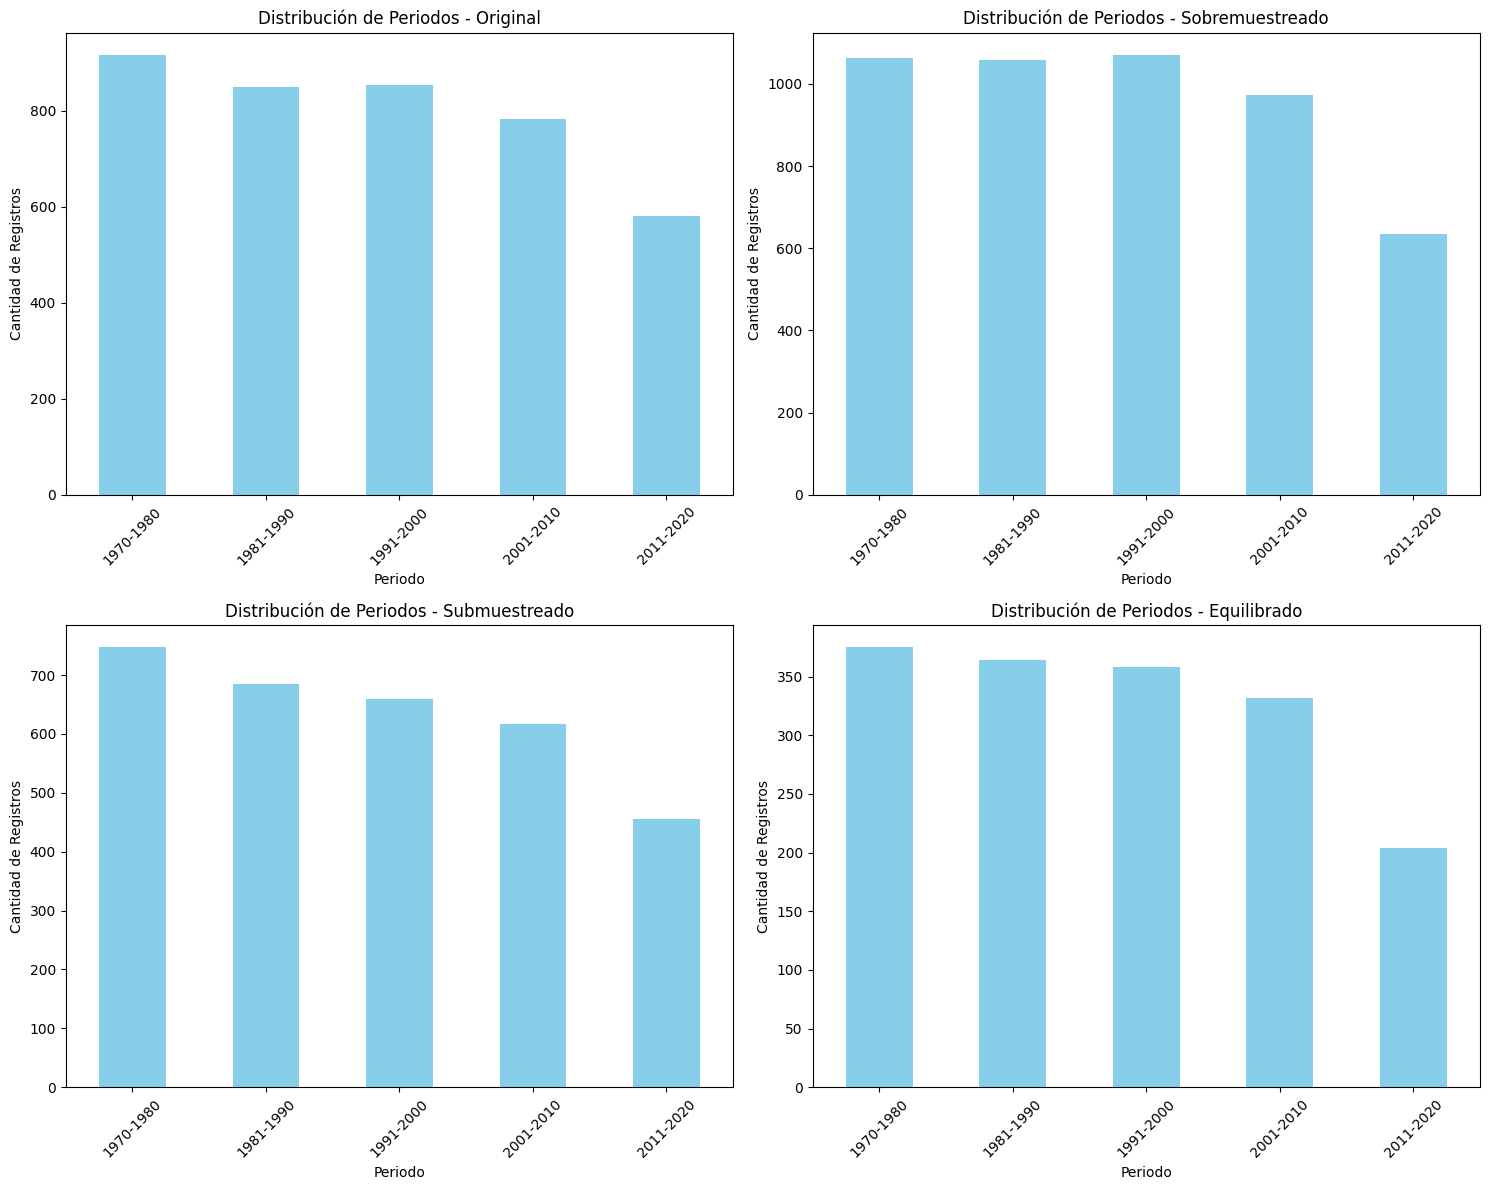

In [ ]:
# Lista de datasets a graficar
datasets = [original, df_sobremuestreado, submuestreo, equilibrado]
dataset_names = ['Original', 'Sobremuestreado', 'Submuestreado', 'Equilibrado']

# Crear gráficos de barras para cada dataset
plt.figure(figsize=(15, 12))

for i, df in enumerate(datasets):
    plt.subplot(2, 2, i+1)  # Crear una cuadrícula de 2x2
    df['Periodo'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(f'Distribución de Periodos - {dataset_names[i]}')
    plt.xlabel('Periodo')
    plt.ylabel('Cantidad de Registros')
    plt.xticks(rotation=45)

plt.tight_layout()  # Ajustar el diseño para que no se solapen
plt.show()


Que conclusiones podemos sacar:
* En el dataset Original: La distribución de registros por período parece equilibrada, con el mayor número de registros en los períodos de 1970-1980 y 1991-2000, y el menor número en el período 2011-2020
* En el dataset Sobremuestreado: Como esperabamos, el sobremuestreo ha generado más registros para los períodos más pequeños (1970-1980, 1981-1990, y 1991-2000). Esto ayuda a que los periodos con menos datos en el dataset original tengan una mayor representación.
* En el dataset Submuestreado: Ha reducido los datos de los períodos más representados. Esto es visible ya que los períodos de 1970-1980 y 1981-1990 tienen más registros que los períodos más recientes (2011-2020).
* En el dataset Equilibrado: Este dataset ha sido equilibrado, lo que se refleja en que la cantidad de registros por período es más parecida entre ellos, aunque aún hay algunos períodos con más registros que otros

#### Dividir datasets train-test split

Funcion para dividir en periodos

In [ ]:
# Función para crear los periodos de 10 años
def crear_periodos_10_años(df):
    # Crear una nueva columna de Periodo basado en el Año
    # Los bins deben cubrir rangos de 10 años desde 1970 hasta 2020
    df['Periodo'] = pd.cut(df['Año'], bins=range(1970, 2021, 10), right=False, labels=[f'{i}-{i+9}' for i in range(1970, 2020, 10)])
    return df


Aplicar funcion

In [ ]:
# Aplicar la función a cada dataset para crear los periodos de 10 años
datasets_10_años = [crear_periodos_10_años(df.copy()) for df in [original, df_sobremuestreado, submuestreo, equilibrado]]

# Asignar nombres a los datasets
df_original_10años, df_sobremuestreado_10años, df_submuestreado_10años, df_equilibrado_10años = datasets_10_años


Borrar columna años

In [ ]:
# Eliminar la columna 'Año' después de crear el periodo
df_original_10años = df_original_10años.drop(columns=['Año'])
df_sobremuestreado_10años = df_sobremuestreado_10años.drop(columns=['Año'])
df_submuestreado_10años = df_submuestreado_10años.drop(columns=['Año'])
df_equilibrado_10años = df_equilibrado_10años.drop(columns=['Año'])


In [ ]:
df_original_10años

,Latitud,Longitud,Altitud,Temp_Max,Temp_Min,Temp_Media,Viento_kmH,Presion_Hpa,Precipitacion,Granizo_Si_No,Periodo
0,-38.73,-62.17,83.0,21.318082,8.448219,14.362810,27.800000,1016.500000,248.8,Sí,1970-1979
1,-38.73,-62.17,83.0,22.111233,8.426849,15.025895,27.691667,1018.725000,728.0,Sí,1970-1979
2,-38.73,-62.17,83.0,22.175890,9.043836,15.393315,29.370330,1012.874286,42.2,Sí,1970-1979
3,-38.73,-62.17,83.0,20.574044,7.889344,14.774590,31.680769,1009.433333,342.9,Sí,1970-1979
4,-38.73,-62.17,83.0,22.123562,8.592329,15.082967,24.743820,1013.954762,1250.5,Sí,1970-1979
...,...,...,...,...,...,...,...,...,...,...,...
3977,-33.73,-65.38,486.0,25.596875,8.945480,16.216164,6.255814,1012.040000,1029.9,No,2010-2019
3978,-33.73,-65.38,486.0,24.847826,8.065015,15.700000,6.255814,1012.040000,934.7,Sí,2010-2019
3979,-33.73,-65.38,486.0,26.228804,8.174929,16.216986,6.255814,1012.040000,801.1,Sí,2010-2019
3980,-33.73,-65.38,486.0,26.351852,8.201709,16.294780,6.255814,1012.040000,501.2,No,2010-2019


Train-test split

In [ ]:
# Datasets de 10 años
datasets_10años = [
    df_original_10años, df_sobremuestreado_10años, df_submuestreado_10años, df_equilibrado_10años
]

splits_10años = {}

# Realizar el split para cada dataset de 10 años
for idx, df in enumerate(datasets_10años):
    # Suponiendo que tu columna objetivo es "Granizo_Sino" y las características están en X
    X = df.drop(columns=['Granizo_Si_No'])
    y = df['Granizo_Si_No']

    # Realizar el train-test split (80% entrenamiento, 20% prueba)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Asignar los datasets con nombres específicos
    splits_10años[f'X_train_10_años_{["original", "sobremuestreo", "submuestreado", "equilibrado"][idx]}'] = X_train
    splits_10años[f'X_test_10_años_{["original", "sobremuestreo", "submuestreado", "equilibrado"][idx]}'] = X_test
    splits_10años[f'y_train_10_años_{["original", "sobremuestreo", "submuestreado", "equilibrado"][idx]}'] = y_train
    splits_10años[f'y_test_10_años_{["original", "sobremuestreo", "submuestreado", "equilibrado"][idx]}'] = y_test

# Verificamos los resultados
splits_10años.keys()  # Para ver los nombres de las variables guardadas


dict_keys(['X_train_10_años_original', 'X_test_10_años_original', 'y_train_10_años_original', 'y_test_10_años_original', 'X_train_10_años_sobremuestreo', 'X_test_10_años_sobremuestreo', 'y_train_10_años_sobremuestreo', 'y_test_10_años_sobremuestreo', 'X_train_10_años_submuestreado', 'X_test_10_años_submuestreado', 'y_train_10_años_submuestreado', 'y_test_10_años_submuestreado', 'X_train_10_años_equilibrado', 'X_test_10_años_equilibrado', 'y_train_10_años_equilibrado', 'y_test_10_años_equilibrado'])

#### Transformacion de variables categoricas y numericas

Crear columnas para variables categoricas y numericas en x

In [ ]:
# Columnas categóricas y numéricas en X
columnas_categoricas_X_10años = ['Periodo']  # Variable categórica
columnas_numericas_X_10años = [col for col in splits_10años['X_train_10_años_original'].columns
                               if col not in columnas_categoricas_X_10años]

In [ ]:
print(columnas_categoricas_X_10años)
print(columnas_numericas_X_10años)

['Periodo']
['Latitud', 'Longitud', 'Altitud', 'Temp_Max', 'Temp_Min', 'Temp_Media', 'Viento_kmH', 'Presion_Hpa', 'Precipitacion']


Crear pipeline para transformaciones cateogricas y numericas en X

In [ ]:
# Pipeline para X
preprocesador_X_10años = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), columnas_categoricas_X_10años),  # OneHotEncoder para 'Periodo'
        ('num', StandardScaler(), columnas_numericas_X_10años)   # StandardScaler para columnas numéricas
    ])

Instancias pipeline en X

In [ ]:
# Crear la pipeline completa para X de 10 años (con ColumnTransformer)
pipeline_X_10años = Pipeline(steps=[('preprocessor_X', preprocesador_X_10años)])

In [ ]:
pipeline_X_10años

Pipeline(steps=[('preprocessor_X',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Periodo']),
                                                 ('num', StandardScaler(),
                                                  ['Latitud', 'Longitud',
                                                   'Altitud', 'Temp_Max',
                                                   'Temp_Min', 'Temp_Media',
                                                   'Viento_kmH', 'Presion_Hpa',
                                                   'Precipitacion'])]))])

Transformar Y directamente

In [ ]:
# Transformación de y (con manejo explícito de tipos)
def transformar_y(y):
    y_transformed = y.replace({'Sí': 1, 'No': 0})
    return y_transformed.astype(int)  # Asegura que el tipo sea entero

Aplicamos la pipeline para transformar X e Y en los 4 datasets de 10 años

In [ ]:
# Original X
X_train_10_años_original = pipeline_X_10años.fit_transform(splits_10años['X_train_10_años_original'])
X_test_10_años_original = pipeline_X_10años.transform(splits_10años['X_test_10_años_original'])

# Original Y
y_train_10_años_original = transformar_y(splits_10años['y_train_10_años_original'])
y_test_10_años_original = transformar_y(splits_10años['y_test_10_años_original'])

# Sobremuestreo X
X_train_10_años_sobremuestreo = pipeline_X_10años.fit_transform(splits_10años['X_train_10_años_sobremuestreo'])
X_test_10_años_sobremuestreo = pipeline_X_10años.transform(splits_10años['X_test_10_años_sobremuestreo'])

# Sobremuestreo Y
y_train_10_años_sobremuestreo = transformar_y(splits_10años['y_train_10_años_sobremuestreo'])
y_test_10_años_sobremuestreo = transformar_y(splits_10años['y_test_10_años_sobremuestreo'])

# Submuestreo X
X_train_10_años_submuestreado = pipeline_X_10años.fit_transform(splits_10años['X_train_10_años_submuestreado'])
X_test_10_años_submuestreado = pipeline_X_10años.transform(splits_10años['X_test_10_años_submuestreado'])

# Submuestreo Y
y_train_10_años_submuestreado = transformar_y(splits_10años['y_train_10_años_submuestreado'])
y_test_10_años_submuestreado = transformar_y(splits_10años['y_test_10_años_submuestreado'])

# Equilibrado X
X_train_10_años_equilibrada = pipeline_X_10años.fit_transform(splits_10años['X_train_10_años_equilibrado'])
X_test_10_años_equilibrada = pipeline_X_10años.transform(splits_10años['X_test_10_años_equilibrado'])

# Equilibrado Y
y_train_10_años_equilibrada = transformar_y(splits_10años['y_train_10_años_equilibrado'])
y_test_10_años_equilibrada = transformar_y(splits_10años['y_test_10_años_equilibrado'])



<ipython-input-76-5d55c9eab1c4>:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-76-5d55c9eab1c4>:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-76-5d55c9eab1c4>:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-76-5d55c9eab1c4>:3: FutureWarning:

Downcastin

Ahora vamos a recuperar las columnas para ver como queda luego de la transformacion

In [ ]:
columnas_transformadas=pipeline_X_10años.named_steps['preprocessor_X'].get_feature_names_out()
Xdf_tansformado_10_años=pd.DataFrame(X_train_10_años_original,columns=columnas_transformadas)

In [ ]:
Xdf_tansformado_10_años.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3185 entries, 0 to 3184
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cat__Periodo_1970-1979  3185 non-null   float64
 1   cat__Periodo_1980-1989  3185 non-null   float64
 2   cat__Periodo_1990-1999  3185 non-null   float64
 3   cat__Periodo_2000-2009  3185 non-null   float64
 4   cat__Periodo_2010-2019  3185 non-null   float64
 5   num__Latitud            3185 non-null   float64
 6   num__Longitud           3185 non-null   float64
 7   num__Altitud            3185 non-null   float64
 8   num__Temp_Max           3185 non-null   float64
 9   num__Temp_Min           3185 non-null   float64
 10  num__Temp_Media         3185 non-null   float64
 11  num__Viento_kmH         3185 non-null   float64
 12  num__Presion_Hpa        3185 non-null   float64
 13  num__Precipitacion      3185 non-null   float64
dtypes: float64(14)
memory usage: 348.5 KB


### Períodos de 5 años

#### Observacion de distribuciones

In [ ]:
# Función para crear los periodos de 5 años
def crear_periodos_5_anos(df):
    # Crear una nueva columna de Periodo basado en el Año
    # Ajustar el rango de bins hasta el año 2020
    df['Periodo'] = pd.cut(df['Año'], bins=range(1970, 2021, 5), right=False, labels=[f'{i}-{i+4}' for i in range(1970, 2016, 5)])
    return df

# Aplicar la función a cada dataset
datasets_5_anos = [crear_periodos_5_anos(df.copy()) for df in datasets]


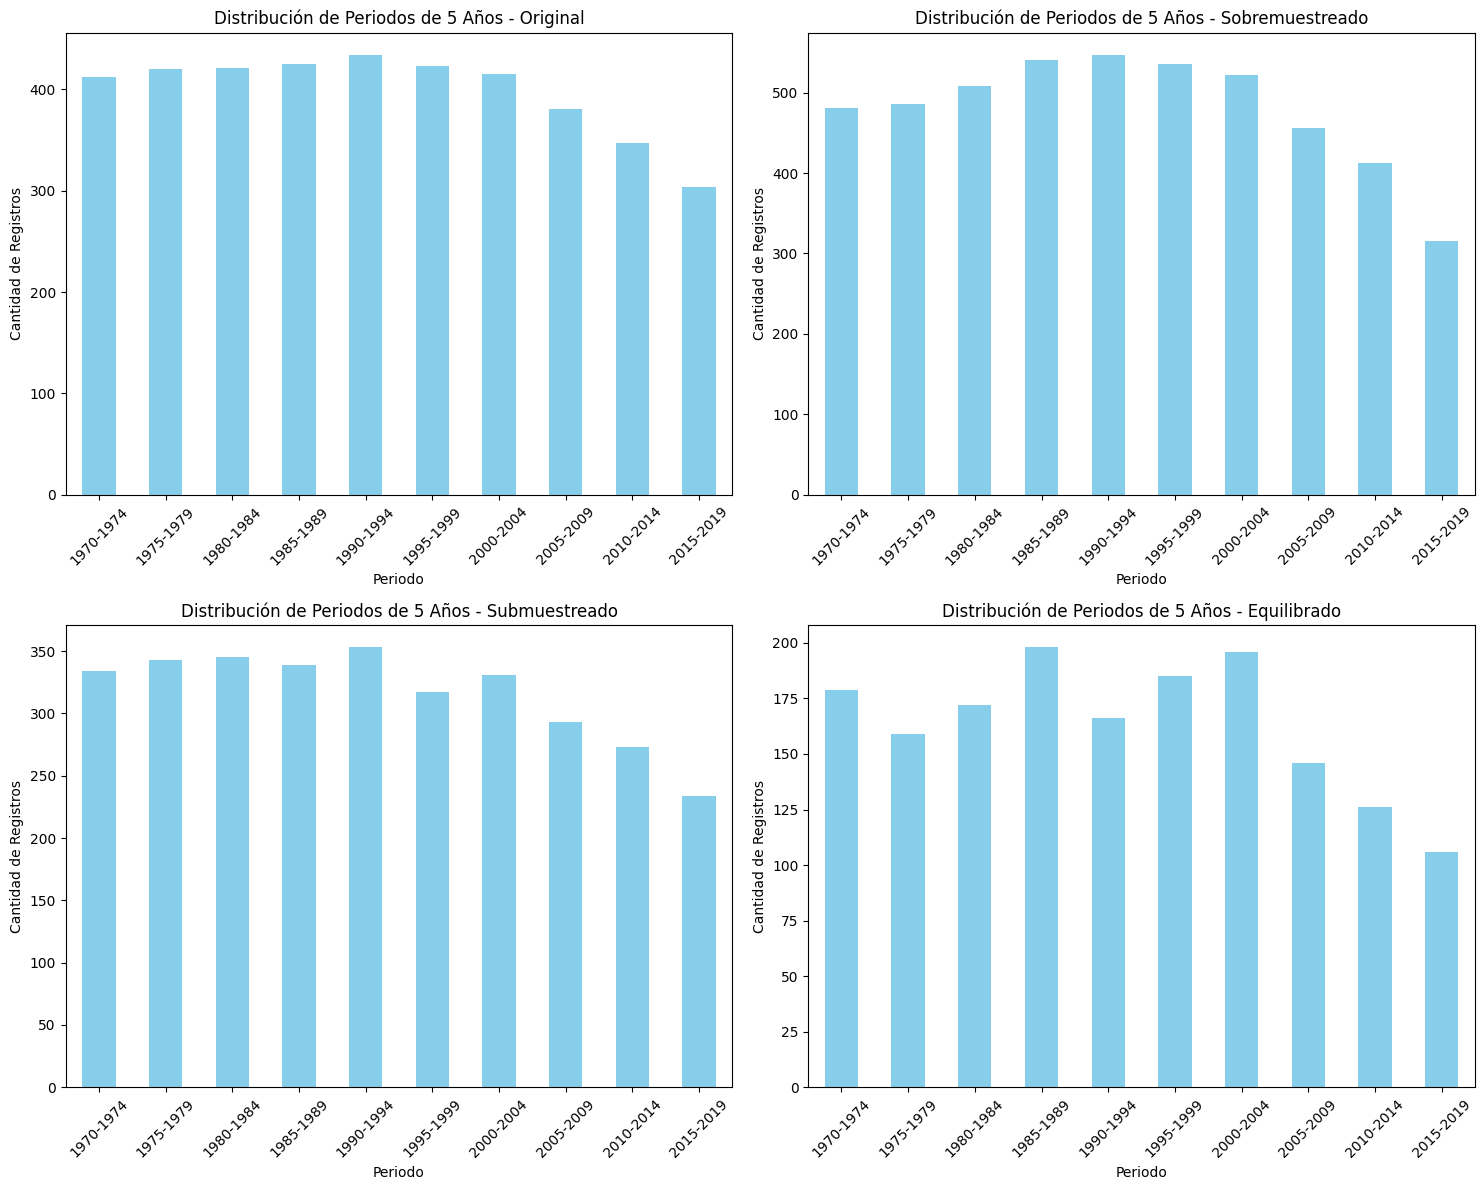

In [ ]:
# Crear gráficos de barras para la distribución de periodos de 5 años
plt.figure(figsize=(15, 12))

for i, df in enumerate(datasets_5_anos):
    plt.subplot(2, 2, i+1)  # Crear una cuadrícula de 2x2
    df['Periodo'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(f'Distribución de Periodos de 5 Años - {dataset_names[i]}')
    plt.xlabel('Periodo')
    plt.ylabel('Cantidad de Registros')
    plt.xticks(rotation=45)

plt.tight_layout()  # Ajustar el diseño para que no se solapen
plt.show()


Que conclusiones podemos sacar:
* En el dataset Original: El número de registros es bastante equilibrado entre los diferentes periodos, aunque el periodo 2015-2019 tiene menos datos, lo cual es esperado ya que es el más reciente.
* En el dataset Sobremuestreado: La distribución también está equilibrada, y los datos están correctamente replicados para igualar las clases.
* En el dataset Submuestreado: La cantidad de registros sigue un patrón similar al original, pero con menos datos en general.
* En el dataset Equilibrado: Se observa una reducción en el número de registros, que es lo esperado al realizar un balance entre clases.

#### Dividir datasets train-test split

Funcion para dividir en periodos

In [ ]:
def crear_periodos_5_años(df):
    # Ajustar el rango de bins hasta el año 2020 cada 5 años
    df['Periodo'] = pd.cut(df['Año'], bins=range(1970, 2021, 5), right=False, labels=[f'{i}-{i+4}' for i in range(1970, 2016, 5)])
    return df


Aplicar funcion

In [ ]:
# Aplicar la función a cada dataset para crear los periodos de 5 años
datasets_5_años = [crear_periodos_5_años(df.copy()) for df in [original, df_sobremuestreado, submuestreo, equilibrado]]

# Asignar nombres a los datasets
df_original_5años, df_sobremuestreado_5años, df_submuestreado_5años, df_equilibrado_5años = datasets_5_años

Borrar columna años

In [ ]:
# Eliminar la columna 'Año' después de crear el periodo
df_original_5años = df_original_5años.drop(columns=['Año'])
df_sobremuestreado_5años = df_sobremuestreado_5años.drop(columns=['Año'])
df_submuestreado_5años = df_submuestreado_5años.drop(columns=['Año'])
df_equilibrado_5años = df_equilibrado_5años.drop(columns=['Año'])

Train-test split

In [ ]:
# Datasets de 5 años
datasets_5años = [
    df_original_5años, df_sobremuestreado_5años, df_submuestreado_5años, df_equilibrado_5años
]

splits_5años = {}

# Realizar el split para cada dataset de 5 años
for idx, df in enumerate(datasets_5años):
    # Suponiendo que tu columna objetivo es "Granizo_Sino" y las características están en X
    X = df.drop(columns=['Granizo_Si_No'])
    y = df['Granizo_Si_No']

    # Realizar el train-test split (80% entrenamiento, 20% prueba)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Asignar los datasets con nombres específicos
    splits_5años[f'X_train_5_años_{["original", "sobremuestreo", "submuestreado", "equilibrado"][idx]}'] = X_train
    splits_5años[f'X_test_5_años_{["original", "sobremuestreo", "submuestreado", "equilibrado"][idx]}'] = X_test
    splits_5años[f'y_train_5_años_{["original", "sobremuestreo", "submuestreado", "equilibrado"][idx]}'] = y_train
    splits_5años[f'y_test_5_años_{["original", "sobremuestreo", "submuestreado", "equilibrado"][idx]}'] = y_test

# Verificamos los resultados
splits_5años.keys()  # Para ver los nombres de las variables guardadas


dict_keys(['X_train_5_años_original', 'X_test_5_años_original', 'y_train_5_años_original', 'y_test_5_años_original', 'X_train_5_años_sobremuestreo', 'X_test_5_años_sobremuestreo', 'y_train_5_años_sobremuestreo', 'y_test_5_años_sobremuestreo', 'X_train_5_años_submuestreado', 'X_test_5_años_submuestreado', 'y_train_5_años_submuestreado', 'y_test_5_años_submuestreado', 'X_train_5_años_equilibrado', 'X_test_5_años_equilibrado', 'y_train_5_años_equilibrado', 'y_test_5_años_equilibrado'])

#### Transformacion de variables categoricas y numericas

Crear columnas para variables categoricas y numericas

In [ ]:
# Columnas categóricas y numéricas en X
columnas_categoricas_X_5años = ['Periodo']  # Variable categórica
columnas_numericas_X_5años = [col for col in splits_5años['X_train_5_años_original'].columns
                               if col not in columnas_categoricas_X_5años]

In [ ]:
print(columnas_categoricas_X_5años)
print(columnas_numericas_X_5años)

['Periodo']
['Latitud', 'Longitud', 'Altitud', 'Temp_Max', 'Temp_Min', 'Temp_Media', 'Viento_kmH', 'Presion_Hpa', 'Precipitacion']


Crear pipeline para transformaciones cateogricas y numericas en X

In [ ]:
# Pipeline para X
preprocesador_X_5años = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), columnas_categoricas_X_5años),  # OneHotEncoder para 'Periodo'
        ('num', StandardScaler(), columnas_numericas_X_5años)   # StandardScaler para columnas numéricas
    ])

Instancias pipeline en X

In [ ]:
# Crear la pipeline completa para X de 10 años (con ColumnTransformer)
pipeline_X_5años = Pipeline(steps=[('preprocessor_X', preprocesador_X_5años)])

In [ ]:
pipeline_X_5años

Pipeline(steps=[('preprocessor_X',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Periodo']),
                                                 ('num', StandardScaler(),
                                                  ['Latitud', 'Longitud',
                                                   'Altitud', 'Temp_Max',
                                                   'Temp_Min', 'Temp_Media',
                                                   'Viento_kmH', 'Presion_Hpa',
                                                   'Precipitacion'])]))])

Transformar Y directamente

In [ ]:
# Transformación de y (con manejo explícito de tipos)
def transformar_y(y):
    y_transformed = y.replace({'Sí': 1, 'No': 0})
    return y_transformed.astype(int)  # Asegura que el tipo sea entero

Aplicamos la pipeline para transformar X e Y en los 4 datasets de 5 años

In [ ]:
# Original X
X_train_5_años_original = pipeline_X_5años.fit_transform(splits_5años['X_train_5_años_original'])
X_test_5_años_original = pipeline_X_5años.transform(splits_5años['X_test_5_años_original'])

# Original Y
y_train_5_años_original = transformar_y(splits_5años['y_train_5_años_original'])
y_test_5_años_original = transformar_y(splits_5años['y_test_5_años_original'])

# Sobremuestreo X
X_train_5_años_sobremuestreo = pipeline_X_5años.fit_transform(splits_5años['X_train_5_años_sobremuestreo'])
X_test_5_años_sobremuestreo = pipeline_X_5años.transform(splits_5años['X_test_5_años_sobremuestreo'])

# Sobremuestreo Y
y_train_5_años_sobremuestreo = transformar_y(splits_5años['y_train_5_años_sobremuestreo'])
y_test_5_años_sobremuestreo = transformar_y(splits_5años['y_test_5_años_sobremuestreo'])

# Submuestreo X
X_train_5_años_submuestreado = pipeline_X_5años.fit_transform(splits_5años['X_train_5_años_submuestreado'])
X_test_5_años_submuestreado = pipeline_X_5años.transform(splits_5años['X_test_5_años_submuestreado'])

# Submuestreo Y
y_train_5_años_submuestreado = transformar_y(splits_5años['y_train_5_años_submuestreado'])
y_test_5_años_submuestreado = transformar_y(splits_5años['y_test_5_años_submuestreado'])

# Equilibrado X
X_train_5_años_equilibrada = pipeline_X_5años.fit_transform(splits_5años['X_train_5_años_equilibrado'])
X_test_5_años_equilibrada = pipeline_X_5años.transform(splits_5años['X_test_5_años_equilibrado'])

# Equilibrado Y
y_train_5_años_equilibrada = transformar_y(splits_5años['y_train_5_años_equilibrado'])
y_test_5_años_equilibrada = transformar_y(splits_5años['y_test_5_años_equilibrado'])



<ipython-input-91-5d55c9eab1c4>:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-91-5d55c9eab1c4>:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-91-5d55c9eab1c4>:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-91-5d55c9eab1c4>:3: FutureWarning:

Downcastin

Ahora vamos a recuperar las columnas para ver como queda luego de la transformacion

In [ ]:
columnas_transformadas=pipeline_X_5años.named_steps['preprocessor_X'].get_feature_names_out()
Xdf_tansformado_5_años=pd.DataFrame(X_train_5_años_original,columns=columnas_transformadas)

In [ ]:
Xdf_tansformado_5_años.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3185 entries, 0 to 3184
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cat__Periodo_1970-1974  3185 non-null   float64
 1   cat__Periodo_1975-1979  3185 non-null   float64
 2   cat__Periodo_1980-1984  3185 non-null   float64
 3   cat__Periodo_1985-1989  3185 non-null   float64
 4   cat__Periodo_1990-1994  3185 non-null   float64
 5   cat__Periodo_1995-1999  3185 non-null   float64
 6   cat__Periodo_2000-2004  3185 non-null   float64
 7   cat__Periodo_2005-2009  3185 non-null   float64
 8   cat__Periodo_2010-2014  3185 non-null   float64
 9   cat__Periodo_2015-2019  3185 non-null   float64
 10  num__Latitud            3185 non-null   float64
 11  num__Longitud           3185 non-null   float64
 12  num__Altitud            3185 non-null   float64
 13  num__Temp_Max           3185 non-null   float64
 14  num__Temp_Min           3185 non-null   

## Modelado

### Instanciamos y importamos librerias necesarias para los modelos

Para consolidar el proyecto vamos a hacer uso de varios modelos de machine learning, ademas a utilizar nuestros 8 datasets para comprobar si los modelos son capaces de obtner mejores resutlados segun la temporalidad.

Y como modelos vamos a utilizar:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* XGBoost Classifier
* CatBoost Classifier
* LGBM Classifier

Instalamos catboost y lightgbm

In [ ]:
!pip install catboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.4 MB/s eta 0:00:00


Importar modelos correspondientes

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

### Creamos la gridsearch con los modelos a utilizar

Generar diccionario de modelos

In [ ]:
modelos = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {'model__C': [0.1, 1, 10]}
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {'model__max_depth': [3, 5, None]}
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [50, 100], 'model__max_depth': [None, 10]}
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5]}
    },
    'CatBoostClassifier': {
        'model': CatBoostClassifier(learning_rate=0.1, iterations=500, depth=3, verbose=0),
        'params': {'model__iterations': [500, 1000], 'model__depth': [3, 5], 'model__learning_rate': [0.01, 0.1]}
    },
    'LGBMClassifier': {
        'model': lgb.LGBMClassifier(),
        'params': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5], 'model__learning_rate': [0.01, 0.1]}
    }
}

### Cargar diccionario de datasets a utilizar

In [ ]:
# Definir los datasets de entrenamiento
datasets = {
    '5_años_original': (X_train_5_años_original, y_train_5_años_original),
    '5_años_sobremuestreo': (X_train_5_años_sobremuestreo, y_train_5_años_sobremuestreo),
    '5_años_submuestreado': (X_train_5_años_submuestreado, y_train_5_años_submuestreado),
    '5_años_equilibrado:': (X_train_5_años_equilibrada, y_train_5_años_equilibrada),
    '10_años_original': (X_train_10_años_original, y_train_10_años_original),
    '10_años_sobremuestreo': (X_train_10_años_sobremuestreo, y_train_10_años_sobremuestreo),
    '10_años_submuestreado': (X_train_10_años_submuestreado, y_train_10_años_submuestreado),
    '10_años_equilibrado': (X_train_10_años_equilibrada, y_train_10_años_equilibrada)
}

# Lista para almacenar los resultados de la GridSearchCV
resultados = []


### GridSeachCV sobre cada dataset y modelo

In [ ]:
# Iterar sobre los datasets de entrenamiento
for nombre_ds, (X_train, y_train) in datasets.items():
    print(f"Procesando dataset: {nombre_ds}")

    # Pipeline genérico
    pipeline = Pipeline([
        ('model', 'passthrough')  # Inicialmente el modelo es 'passthrough'
    ])

    # Realizar GridSearchCV para cada modelo
    for nombre_modelo, config in modelos.items():
        search = GridSearchCV(
            pipeline,
            param_grid={'model': [config['model']], **config['params']},
            scoring='accuracy',
            cv=5,  # Validación cruzada
            n_jobs=-1
        )
        search.fit(X_train, y_train)

        # Almacenar los resultados
        resultados.append({
            'dataset': nombre_ds,
            'modelo': nombre_modelo,
            'mejores_params': search.best_params_,
            'accuracy_cv': search.best_score_
        })


Procesando dataset: 5_años_original
[LightGBM] [Info] Number of positive: 1920, number of negative: 1265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of data points in the train set: 3185, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.602826 -> initscore=0.417253
[LightGBM] [Info] Start training from score 0.417253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [ ]:
# Convertir los resultados a un DataFrame para análisis
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# Seleccionar el mejor modelo basado en el accuracy en la validación cruzada
mejor_resultado = df_resultados.loc[df_resultados['accuracy_cv'].idxmax()]
print("\nMejor modelo seleccionado:")
print(mejor_resultado)


                  dataset                  modelo  \
0         5_años_original      LogisticRegression   
1         5_años_original  DecisionTreeClassifier   
2         5_años_original  RandomForestClassifier   
3         5_años_original           XGBClassifier   
4         5_años_original      CatBoostClassifier   
5         5_años_original          LGBMClassifier   
6    5_años_sobremuestreo      LogisticRegression   
7    5_años_sobremuestreo  DecisionTreeClassifier   
8    5_años_sobremuestreo  RandomForestClassifier   
9    5_años_sobremuestreo           XGBClassifier   
10   5_años_sobremuestreo      CatBoostClassifier   
11   5_años_sobremuestreo          LGBMClassifier   
12   5_años_submuestreado      LogisticRegression   
13   5_años_submuestreado  DecisionTreeClassifier   
14   5_años_submuestreado  RandomForestClassifier   
15   5_años_submuestreado           XGBClassifier   
16   5_años_submuestreado      CatBoostClassifier   
17   5_años_submuestreado          LGBMClassif

In [ ]:
# Obtener el dataset y modelo ganador
mejor_dataset = mejor_resultado['dataset']
X_train_mejor, y_train_mejor = datasets[mejor_dataset]
mejor_modelo = modelos[mejor_resultado['modelo']]['model']

# Filtrar el diccionario de parámetros para asegurarte que solo contiene los válidos
# Asegúrate de que los parámetros sean correctos para el modelo que estás usando
valid_params = {k: v for k, v in mejor_resultado['mejores_params'].items() if k in mejor_modelo.get_params()}

# Establecer los parámetros del modelo
mejor_modelo.set_params(**valid_params)

# Verifica que el modelo tenga ahora los parámetros correctos
print(mejor_modelo.get_params())


{'iterations': 500, 'learning_rate': 0.1, 'depth': 3, 'verbose': 0}


A continuacion luego de generar todas las posibles combinaciones para nuestros datasets y modelos, vamos a observar graficamente cual es el mejor modelo.

### Resultados

#### Top 10 modelos por precision en validacion cruzada

In [ ]:
# Ordenar los resultados por 'accuracy_cv' y seleccionar el top 10
df_resultados_sorted = df_resultados.sort_values(by='accuracy_cv', ascending=False).head(10)

# Crear el gráfico de barras interactivo
fig = px.bar(
    df_resultados_sorted,
    x='accuracy_cv',
    y='modelo',
    color='dataset',
    orientation='h',
    text='accuracy_cv',
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title='Top 10 Modelos por Precisión en Validación Cruzada'
)

# Ajustar etiquetas y diseño
fig.update_layout(
    xaxis_title='Precisión Media (Cross-Validation)',
    yaxis_title='Modelo',
    legend_title='Dataset',
    template='plotly_white'
)

fig.show()


Lo primero que podemos observar es que nuestro modelo ganador es CatBoostClassifier con el dataset de 5 años equlibrado.

Esto ademas de ser muy gratificante por su performance, que fue de 0.92.

No demuestra lo importante que es utilizar un buen metodo para equilibrar clases si las tenemos descompensadas.



#### Precision por modelo y dataset

In [ ]:
import plotly.graph_objects as go

# Crear una tabla pivote
pivot_table = df_resultados.pivot(index='modelo', columns='dataset', values='accuracy_cv')

# Crear el heatmap interactivo
fig = go.Figure(data=go.Heatmap(
    z=pivot_table.values,
    x=pivot_table.columns,
    y=pivot_table.index,
    colorscale='Viridis',
    colorbar_title='Precisión'
))

fig.update_layout(
    title='Heatmap de Precisión por Modelo y Dataset',
    xaxis_title='Dataset',
    yaxis_title='Modelo',
    template='plotly_white'
)

fig.show()


Aca podemos observar aun mas la importancia de las tecnicas para equipara clases, ya que los datasets original,sobremuestreo y sub muestreo posen una presicion en promedio inferior a 0.65, ademas vemos como modelos mas basicos como regresion logistica para este problema obtienen una baja puntuacion.

### Entrenamiento del modelo

#### Entrenamiento

Vamos a entrenar al modelo ganador

In [ ]:
print(f"Entrenando el mejor modelo en el dataset: {mejor_dataset}")

Entrenando el mejor modelo en el dataset: 5_años_equilibrado:


Utilizamos los datos del modelo ganador

In [ ]:
X_train_mejor = X_train_5_años_equilibrada
y_train_mejor = y_train_5_años_equilibrada

Entrenamos el modelo

In [ ]:
# Entrenar el modelo
mejor_modelo.fit(X_train_mejor, y_train_mejor)

#### Evaluacion

Evaluamos el modelo con el conjunto de prueba del dataset ganador

In [ ]:
X_test = X_test_5_años_equilibrada
y_test = y_test_5_años_equilibrada


In [ ]:
y_pred = mejor_modelo.predict(X_test)


Métricas de evaluación

##### Precision / Recall / F1-Score

In [ ]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       163
           1       0.89      0.94      0.91       164

    accuracy                           0.91       327
   macro avg       0.91      0.91      0.91       327
weighted avg       0.91      0.91      0.91       327



Como podemos observar en el reporte de clasificación, el modelo tiene un desempeño bastante bueno.

* Precisión (Precision): El modelo presenta un alto porcentaje de aciertos para la clase "0", mientras que sus métricas disminuyen ligeramente cuando se trata de eventos de granizo. Sin embargo, esto sigue siendo eficaz para minimizar los falsos positivos.

* Recall (Sensibilidad): El modelo demuestra un gran porcentaje de detección para los casos positivos, lo que lo hace efectivo en la reducción de falsos negativos.

* F1-Score: La combinación de precisión y recall no es una métrica clave en este caso, ya que el dataset ganador no presenta un desequilibrio significativo de clases. Además, gracias al método SMOTEENN que utilizamos para equilibrar las clases, esta diferencia se redujo considerablemente.



##### Matriz de Confusión

In [ ]:
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


Matriz de Confusión:
[[144  19]
 [ 10 154]]


Como vemos en esta matriz de confusion el modelo performa bastante bien y tiene pocos casos de falsos positivos y falsos negativos

##### Curva AUC-ROC

In [ ]:
if len(set(y_test)) == 2:
    y_prob = mejor_modelo.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"AUC-ROC: {auc_score:.4f}")

    # Gráfico de la curva Roc
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Baseline', line=dict(dash='dash')))
    fig.update_layout(
        title=f'Curva ROC (AUC = {auc_score:.2f})',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate'
    )
    fig.show()


AUC-ROC: 0.9614


Como se ve en nuestra curva Roc el modelo tiene una excelente capacidad para seprara las clases positivas y negativas, ya que su puntaje fue de 0.96.



## Interpretabilidad

### ¿Como le damos interpretabilidad?

Para entender mejor como funciona este modelo y responder algunas preguntas como:
* ¿Como llega a ciertos resultados?

* ¿Que variable es mas "importante" en terminos generalistas?

* ¿Como explicar algunas decisiones?

Vamos a utlizar la libreria SHAP, para generar graficos que nos ayuden a darle cierta interpretabilidad a este tipo de modelos (caja negra)

In [ ]:
# Instalamos las dependencias necesarias
!pip install shap

In [ ]:
# Importamos la libreria
import shap

Iniciamos el modelo SHAP

In [ ]:
# Obtener los nombres de las columnas transformadas desde el pipeline ajustado
columnas_transformadas = pipeline_X_5años.named_steps['preprocessor_X'].get_feature_names_out()

# Convertimos en un DataFrame
X_train_equilibrada_df = pd.DataFrame(X_train_5_años_equilibrada, columns=columnas_transformadas)

# Crear explainer
explainer = shap.Explainer(mejor_modelo, X_train_5_años_equilibrada)

# Valores shap
shap_values = explainer(X_train_5_años_equilibrada)

# usar las columnas del df de columnas_transformadas
shap_values.feature_names = columnas_transformadas



 95%|=================== | 1244/1306 [00:14<00:00]       

### Graficos sobre la interpretabilidad

#### Importancia global de las variables

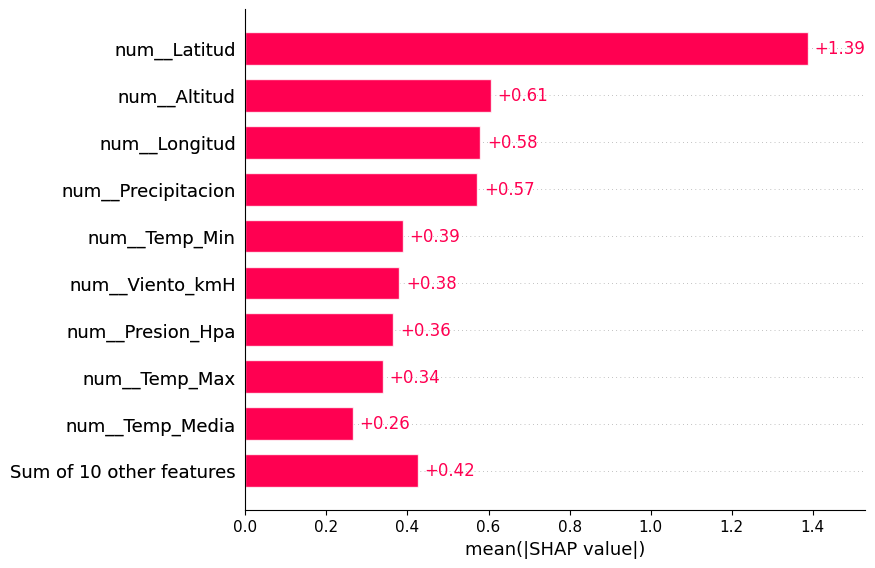

In [ ]:
shap.plots.bar(shap_values, show=True)

Aquí podemos observar cómo el modelo le da especial importancia a variables como latitud y longitud, lo cual es comprensible debido a la cantidad de incidentes que ocurrieron en Buenos Aires. Esto sugiere que el modelo está identificando una fuerte relación con estas variables.

Este comportamiento es muy útil, ya que puede ayudarnos a predecir futuros patrones en zonas más afectadas según su latitud y longitud.

Además, al excluir las variables de longitud, latitud y altitud, notamos que la precipitación también juega un papel importante. En los gráficos iniciales, no parecía haber una relación tan fuerte, pero el modelo ahora muestra una conexión significativa.

#### Importancia local de las variables

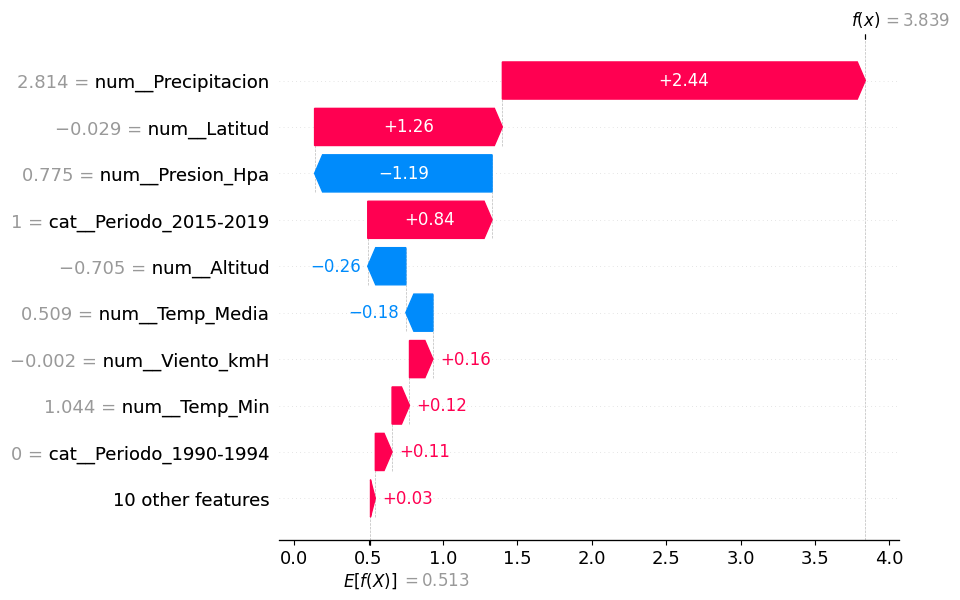

In [ ]:
# Observacion logal
indice_observacion = 1 # Cambiamos segun necesiada
shap.plots.waterfall(shap_values[indice_observacion])

Como se observa de manera local no siempre todo esta dado por latitud y longitud, en este caso, para el registro 1. Vemos una fuerte relacion del granizo o la posibilidad de una tormenta de granizo con la precipitacion.

#### Impacto de cada variable  a nivel global

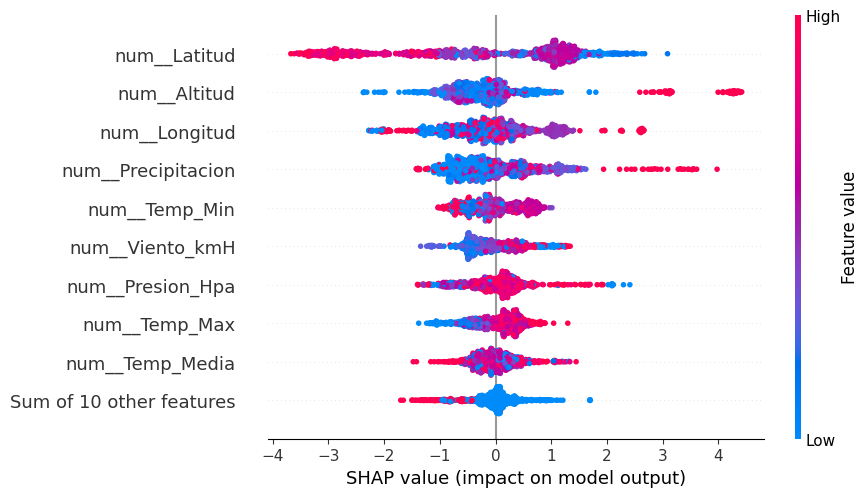

In [ ]:
shap.plots.beeswarm(shap_values, max_display=10)

Como podemos observar en este gráfico, cada punto representa un registro de nuestro dataset (Granizo=1 / Granizo=0). En color rosado intenso, se muestra el impacto de esa variable en cada registro. Al igual que en los análisis anteriores, se puede ver que variables como latitud, longitud, altitud y presión tienen una fuerte relación con los datos. En cambio, variables como temperatura media y viento resultan ser menos relevantes.



## Gracias!

En primer lugar me gustaria expresar mi agradecimiento a mi profesor **Fernando Carabedo** y a Coderhouse por su apoyo en todo el proceso de aprendizaje y guiar clase a clase para que uno pueda desarrollar habilidades en el mundo de la Ciencia de Datos


Tambien expresar que este no es el fin del proyecto, la idea es generar algo util para los ciudadanos del dia a dia

Tambien contarles que es muy dificil la optencion de datos climaticos de gran volumen y sobre todo que sean de buena calidad y en lo posible gratuitos, existen muy pocos servicios.

Uno de ellos fue el que ayudo a que esta idea sea posible

Gracias a https://dev.meteostat.net/ por proporcionar datos climaticos historicos sobre Argentina, en especial sus creadors:
* [Christian Lamprecht ](https://github.com/clampr)
* [Rafael Franco](https://github.com/rfoel)



Pero sobre todas para un proyecto de este estilo, como es el tema del granizo, es algo totalmente innovador, ya que hay muy pocos proyectos por el estilo y es sumamente dificil encontrar datos sobre el granizo.

Por eso el agradecimiento mas especial es para [Mezher, Romina Nahir.](https://github.com/RomiNahir)

La creador de uno de los primeros datasets sobre el granizo.

Nada de esto hubiese sido posible sin su datasets de frecuencias.

[Plataforma de datos de granizo de Argentina - Mezher, Romina Nahir](https://repositorio.inta.gob.ar/xmlui/handle/20.500.12123/11671#)




## Abstract Granizo - Nahuel Ghilardi

Link de Github:
[Abstract Granizo - Nahuel Ghilardi](https://github.com/Nahuelito22/ProyectoDS2_Nahuel_Ghilardi/blob/main/Nahuel_Ghilardi_Abastract_Granizo.pdf)

Link de Drive:
[Abstract Granizo - Nahuel Ghilardi](https://drive.google.com/file/d/1tK2ocNXESFOnDz7SZGb1ID256LURHx7S/view?usp=drive_link)
